In [13]:
import logging, os
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import warnings
warnings.filterwarnings('ignore')

In [14]:
import pickle as pkl
import pandas as pd
import numpy as np
from numpy.random import RandomState
rng = RandomState(93748573)
from pprint import pprint

In [15]:
from gensim import models
from gensim.corpora import Dictionary
# Use coherence model to measure the LDA models generated
from gensim.models.coherencemodel import CoherenceModel

In [31]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-poster'])
import seaborn as sns
# ref: http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb
import pyLDAvis.gensim as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
from IPython.display import HTML

# Topic Modelling on [data_schoolofinf](../../data/data_schoolofinf)

! Because of the need to run this script for long hours to find the "best" k number of topics, we use scripts located in [src](../src) for each model

In [5]:
DATA_DIR = '../../data/data_schoolofinf/'

## Corpus used for topic modelling

In [6]:
# Import the dataset:
df_combined_toks = pd.read_pickle(os.path.join(DATA_DIR,'toks', 'toks.combined.pkl'))
df_combined_toks.head(3)

year  \
pub_id                                       
400818dc-63af-4a26-80c5-906f98e1f8ab  1989   
18b1a861-afef-4fff-bc80-d02e05be18c4  2013   
309fdbfc-227b-4588-9264-f0f4e3cadfcb  1994   

                                                                            toks_metada  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  [ballooning, stability, analysis, jet, hmode, ...   
18b1a861-afef-4fff-bc80-d02e05be18c4  [query, processing, data, integration, chapter...   
309fdbfc-227b-4588-9264-f0f4e3cadfcb  [comprehension, syntax, syntax, comprehension,...   

                                                                           toks_pdf2txt  
pub_id                                                                                   
400818dc-63af-4a26-80c5-906f98e1f8ab                                                     
18b1a861-afef-4fff-bc80-d02e05be18c4                                                     
309fdbfc-227b-4588-9264-f0f4e3cadfcb  [comprehension, syntax, citation, published, v...

In [7]:
# Remove unrelevant documents
df_combined_toks = df_combined_toks.drop(
    df_combined_toks[(df_combined_toks.year < 1997) | (df_combined_toks.year > 2017)].index)

# Add empty list so that concat_toks is just an addition of the two list.
df_combined_toks[
    'toks_pdf2txt'] = df_combined_toks.toks_pdf2txt.apply(
        lambda x: [] if not len(x) else x)
df_combined_toks[
    'toks_metada'] = df_combined_toks.toks_metada.apply(
        lambda x: [] if not len(x) else x)

In [8]:
def get_score(num_topic, dictionary, corpus, texts, coherence, model_dir):
    """
    Load a particular topic model and evaluate it with a given measure.
    """
    _model = models.LdaModel.load('{}/ldamodel_nb_topics_{}'.format(
        model_dir, int(num_topic)))
    # topn was 20 by default in the original function
    toptopics = _model.top_topics(
        corpus=corpus, texts=texts, coherence=coherence, dictionary=dictionary, topn=15) 
    avg = sum(t[1] for t in toptopics) / num_topic # Return the average measure
    return avg

In [9]:
def plot_results(df, fname):
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111)
    ax = df.plot(x='num_topic', y='c_v', label='c_v score', legend=True, ax=ax)
    best = df.c_v.argmax()
    ax.scatter(x=df.num_topic.iloc[best], y=df.iloc[best].c_v, c='g', marker='*', s=150)
    ax.set_ylabel('c_v score')
    ax = df.plot(
        x='num_topic',
        y='u_mass',
        secondary_y=True,
        label='u_mass score',
        legend=True,
        ax=ax)
    ax.set_ylabel('u_mass score')

    fig.savefig('IMG/{}.png'.format(fname), format='png', bbox_inches='tight')
    return ax

# 1997-2017 Publications

## `tmfull` : metadata + pdf

In [9]:
dict_all = Dictionary.load(os.path.join(DATA_DIR, 'corpora', 'dictionary.all'))

2018-03-21 01:04:45,585 : INFO : loading Dictionary object from ../../data/data_schoolofinf/corpora/dictionary.all
2018-03-21 01:04:45,634 : INFO : loaded ../../data/data_schoolofinf/corpora/dictionary.all


In [ ]:
df_all = df_combined_toks.copy()
df_all['concat_toks'] = df_combined_toks.apply(
    lambda row: row.toks_metada + row.toks_pdf2txt, axis=1)
# Create a bow tagging for each publication:
df_all['bow'] = df_all['concat_toks'].apply(dict_all.doc2bow)

# Generate a corpus based on the tokens, which we will be using later
corpus_all = df_all.bow.tolist()

In [15]:
# Parameters FOR LDA:
# num_topics = 35 ### SEE THE R-notebook
num_topics = [10, 15, 20, 25, 30, 35, 40, 50]
corpus = corpus_all

### Evaluation

In [51]:
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)
pprint(sorted(top_topics, key=lambda x:x[1]))

Average topic coherence: -0.9181.
[([(0.012109860295782376, 'rule'),
   (0.011954160668630025, 'translation'),
   (0.008373670759038042, 'word'),
   (0.006655420620294776, 'phrase'),
   (0.006348360196802571, 'we'),
   (0.005920755828222334, 'transformation'),
   (0.005698103148114008, 'membrane'),
   (0.004713289781728609, 'pair'),
   (0.004348902248139687, 'language'),
   (0.004275795719942379, 'bx')],
  -1.642803322347795),
 ([(0.02471458781662506, 'ha'),
   (0.022827458383852684, 'de'),
   (0.015455432809436594, 'ai'),
   (0.014307536571297562, 'wi'),
   (0.013477652442305588, 'ea'),
   (0.011854365560615188, 'cb'),
   (0.011591492311808813, 'hi'),
   (0.011276046496331292, 'ei'),
   (0.010481277569387893, 'ca'),
   (0.010132638025028942, 'di')],
  -1.4675729893854692),
 ([(0.0142511633230519, 'feature'),
   (0.01373642854806235, 'speech'),
   (0.012086187432015416, 'synthesis'),
   (0.006070815054217672, 'pp'),
   (0.005912134427187715, 'acoustic'),
   (0.005810176629329417, 'netw

### Visualisation

In [56]:
vis_data = gensimvis.prepare(lda_all, corpus_all, dict_all, mds='tsne', sort_topics=False)

/afs/inf.ed.ac.uk/user/s14/s1450710/miniconda3/envs/infnet3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [57]:
pyLDAvis.display(vis_data,)

In [54]:
# save in html for viewing
pyLDAvis.save_html(vis_data, open(os.path.join(DATA_DIR,'models','tm','tm_model1.visLDA.html'), 'w'))

## `tmfull_meta` : Metadata only
[src/train_tmfull_meta.py](../src/train_tmfull_meta.py)

In [9]:
dict_tmfull_meta = Dictionary.load(
    os.path.join(DATA_DIR, 'corpora', 'dictionary.meta'))
df_metadata = df_combined_toks[['year', 'toks_metada']]
# Create a bow tagging for each publication:
df_metadata['bow'] = df_metadata['toks_metada'].apply(dict_tmfull_meta.doc2bow)

# Generate a corpus based on the tokens, which we will be using later
corpus_tmfull_meta = df_metadata.bow.tolist()
text_tmfull_meta = df_metadata.toks_metada.tolist()

2018-03-25 19:41:45,092 : INFO : loading Dictionary object from ../../data/data_schoolofinf/corpora/dictionary.meta
2018-03-25 19:41:45,098 : INFO : loaded ../../data/data_schoolofinf/corpora/dictionary.meta


In [63]:
tmfull_meta_score = pd.read_csv('../src/tmfull_meta/scores.csv')

### Evaluation of model

In [65]:
tmfull_meta_score['c_v'] = tmfull_meta_score.apply(lambda row: get_score(row.num_topic, dict_tmfull_meta, texts=text_tmfull_meta, corpus=corpus_tmfull_meta, 
                                                                         coherence='c_v', model_dir='../src/tmfull_meta'),
                                                      axis=1)

2018-03-25 19:58:08,017 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_10
2018-03-25 19:58:08,020 : INFO : loading expElogbeta from ../src/tmfull_meta/ldamodel_nb_topics_10.expElogbeta.npy with mmap=None
2018-03-25 19:58:08,021 : INFO : setting ignored attribute dispatcher to None
2018-03-25 19:58:08,022 : INFO : setting ignored attribute state to None
2018-03-25 19:58:08,023 : INFO : setting ignored attribute id2word to None
2018-03-25 19:58:08,024 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_10
2018-03-25 19:58:08,025 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_10.state
2018-03-25 19:58:08,032 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_10.state
2018-03-25 19:58:08,038 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2018-03-25 19:58:12,330 : INFO : serializing accumulator to return to master...
2018-03-25 19:58:12,353 : INFO : acc

2018-03-25 19:59:04,996 : INFO : serializing accumulator to return to master...
2018-03-25 19:59:05,016 : INFO : accumulator serialized
2018-03-25 19:59:05,081 : INFO : serializing accumulator to return to master...
2018-03-25 19:59:05,118 : INFO : accumulator serialized
2018-03-25 19:59:05,177 : INFO : serializing accumulator to return to master...
2018-03-25 19:59:05,196 : INFO : accumulator serialized
2018-03-25 19:59:05,432 : INFO : 3 accumulators retrieved from output queue
2018-03-25 19:59:05,655 : INFO : accumulated word occurrence stats for 91731 virtual documents
2018-03-25 19:59:06,771 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_40
2018-03-25 19:59:06,773 : INFO : loading expElogbeta from ../src/tmfull_meta/ldamodel_nb_topics_40.expElogbeta.npy with mmap=None
2018-03-25 19:59:06,775 : INFO : setting ignored attribute dispatcher to None
2018-03-25 19:59:06,776 : INFO : setting ignored attribute state to None
2018-03-25 19:59:06,777 : INFO : sett

In [66]:
tmfull_meta_score['u_mass'] = tmfull_meta_score.apply(lambda row: get_score(row.num_topic, dict_tmfull_meta, texts=text_tmfull_meta, corpus=corpus_tmfull_meta, 
                                                                            coherence='u_mass', model_dir='../src/tmfull_meta'),
                                                      axis=1)

2018-03-25 19:59:45,054 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_10
2018-03-25 19:59:45,056 : INFO : loading expElogbeta from ../src/tmfull_meta/ldamodel_nb_topics_10.expElogbeta.npy with mmap=None
2018-03-25 19:59:45,058 : INFO : setting ignored attribute dispatcher to None
2018-03-25 19:59:45,059 : INFO : setting ignored attribute state to None
2018-03-25 19:59:45,059 : INFO : setting ignored attribute id2word to None
2018-03-25 19:59:45,060 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_10
2018-03-25 19:59:45,061 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_10.state
2018-03-25 19:59:45,067 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_10.state
2018-03-25 19:59:45,093 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-03-25 19:59:45,121 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-03-25 19:59:45,143 : INFO : CorpusAccumulator accumulated stats from 3000 documen

2018-03-25 19:59:47,014 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-03-25 19:59:47,047 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-03-25 19:59:47,080 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-03-25 19:59:47,118 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-03-25 19:59:47,163 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-03-25 19:59:47,297 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_40
2018-03-25 19:59:47,299 : INFO : loading expElogbeta from ../src/tmfull_meta/ldamodel_nb_topics_40.expElogbeta.npy with mmap=None
2018-03-25 19:59:47,301 : INFO : setting ignored attribute dispatcher to None
2018-03-25 19:59:47,302 : INFO : setting ignored attribute state to None
2018-03-25 19:59:47,303 : INFO : setting ignored attribute id2word to None
2018-03-25 19:59:47,303 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_40
2018-03-25 19:5

In [67]:
tmfull_meta_score['c_npmi'] = tmfull_meta_score.apply(lambda row: get_score(row.num_topic, dict_tmfull_meta, texts=text_tmfull_meta, corpus=corpus_tmfull_meta, 
                                                                            coherence='c_npmi', model_dir='../src/tmfull_meta'),
                                                      axis=1)

2018-03-25 19:59:48,774 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_10
2018-03-25 19:59:48,776 : INFO : loading expElogbeta from ../src/tmfull_meta/ldamodel_nb_topics_10.expElogbeta.npy with mmap=None
2018-03-25 19:59:48,778 : INFO : setting ignored attribute dispatcher to None
2018-03-25 19:59:48,778 : INFO : setting ignored attribute state to None
2018-03-25 19:59:48,779 : INFO : setting ignored attribute id2word to None
2018-03-25 19:59:48,779 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_10
2018-03-25 19:59:48,780 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_10.state
2018-03-25 19:59:48,785 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_10.state
2018-03-25 19:59:48,793 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2018-03-25 19:59:48,884 : INFO : 1 batches submitted to accumulate stats from 64 documents (4982 virtual)
2018-03-25

2018-03-25 19:59:53,823 : INFO : 68 batches submitted to accumulate stats from 4352 documents (355588 virtual)
2018-03-25 19:59:53,979 : INFO : 69 batches submitted to accumulate stats from 4416 documents (360644 virtual)
2018-03-25 19:59:54,011 : INFO : 70 batches submitted to accumulate stats from 4480 documents (365848 virtual)
2018-03-25 19:59:54,083 : INFO : 71 batches submitted to accumulate stats from 4544 documents (370526 virtual)
2018-03-25 19:59:54,191 : INFO : 72 batches submitted to accumulate stats from 4608 documents (375897 virtual)
2018-03-25 19:59:54,263 : INFO : 73 batches submitted to accumulate stats from 4672 documents (381628 virtual)
2018-03-25 19:59:54,323 : INFO : 74 batches submitted to accumulate stats from 4736 documents (386903 virtual)
2018-03-25 19:59:54,412 : INFO : 75 batches submitted to accumulate stats from 4800 documents (391772 virtual)
2018-03-25 19:59:54,502 : INFO : 76 batches submitted to accumulate stats from 4864 documents (396642 virtual)
2

2018-03-25 19:59:58,882 : INFO : 5 batches submitted to accumulate stats from 320 documents (25048 virtual)
2018-03-25 19:59:58,895 : INFO : 6 batches submitted to accumulate stats from 384 documents (30581 virtual)
2018-03-25 19:59:59,054 : INFO : 7 batches submitted to accumulate stats from 448 documents (35845 virtual)
2018-03-25 19:59:59,100 : INFO : 8 batches submitted to accumulate stats from 512 documents (40777 virtual)
2018-03-25 19:59:59,110 : INFO : 9 batches submitted to accumulate stats from 576 documents (45638 virtual)
2018-03-25 19:59:59,237 : INFO : 10 batches submitted to accumulate stats from 640 documents (51118 virtual)
2018-03-25 19:59:59,369 : INFO : 11 batches submitted to accumulate stats from 704 documents (56409 virtual)
2018-03-25 19:59:59,400 : INFO : 12 batches submitted to accumulate stats from 768 documents (61058 virtual)
2018-03-25 19:59:59,433 : INFO : 13 batches submitted to accumulate stats from 832 documents (66886 virtual)
2018-03-25 19:59:59,580 

2018-03-25 20:00:04,568 : INFO : 80 batches submitted to accumulate stats from 5120 documents (415102 virtual)
2018-03-25 20:00:04,638 : INFO : 81 batches submitted to accumulate stats from 5184 documents (420818 virtual)
2018-03-25 20:00:04,704 : INFO : 82 batches submitted to accumulate stats from 5248 documents (426106 virtual)
2018-03-25 20:00:04,798 : INFO : 83 batches submitted to accumulate stats from 5312 documents (431416 virtual)
2018-03-25 20:00:04,854 : INFO : 84 batches submitted to accumulate stats from 5376 documents (437077 virtual)
2018-03-25 20:00:04,964 : INFO : 85 batches submitted to accumulate stats from 5440 documents (442566 virtual)
2018-03-25 20:00:04,979 : INFO : 86 batches submitted to accumulate stats from 5504 documents (448354 virtual)
2018-03-25 20:00:05,134 : INFO : 87 batches submitted to accumulate stats from 5568 documents (453066 virtual)
2018-03-25 20:00:05,156 : INFO : 88 batches submitted to accumulate stats from 5632 documents (458371 virtual)
2

2018-03-25 20:00:10,000 : INFO : 16 batches submitted to accumulate stats from 1024 documents (83693 virtual)
2018-03-25 20:00:10,043 : INFO : 17 batches submitted to accumulate stats from 1088 documents (88824 virtual)
2018-03-25 20:00:10,184 : INFO : 18 batches submitted to accumulate stats from 1152 documents (93843 virtual)
2018-03-25 20:00:10,223 : INFO : 19 batches submitted to accumulate stats from 1216 documents (98507 virtual)
2018-03-25 20:00:10,303 : INFO : 20 batches submitted to accumulate stats from 1280 documents (104200 virtual)
2018-03-25 20:00:10,452 : INFO : 21 batches submitted to accumulate stats from 1344 documents (109596 virtual)
2018-03-25 20:00:10,479 : INFO : 22 batches submitted to accumulate stats from 1408 documents (114736 virtual)
2018-03-25 20:00:10,548 : INFO : 23 batches submitted to accumulate stats from 1472 documents (120412 virtual)
2018-03-25 20:00:10,641 : INFO : 24 batches submitted to accumulate stats from 1536 documents (125964 virtual)
2018-

2018-03-25 20:00:15,936 : INFO : 90 batches submitted to accumulate stats from 5760 documents (468341 virtual)
2018-03-25 20:00:16,086 : INFO : 91 batches submitted to accumulate stats from 5824 documents (473805 virtual)
2018-03-25 20:00:16,107 : INFO : 92 batches submitted to accumulate stats from 5888 documents (479144 virtual)
2018-03-25 20:00:16,235 : INFO : 93 batches submitted to accumulate stats from 5952 documents (484277 virtual)
2018-03-25 20:00:16,275 : INFO : 94 batches submitted to accumulate stats from 6016 documents (490100 virtual)
2018-03-25 20:00:16,413 : INFO : 95 batches submitted to accumulate stats from 6080 documents (495729 virtual)
2018-03-25 20:00:16,459 : INFO : 96 batches submitted to accumulate stats from 6144 documents (500712 virtual)
2018-03-25 20:00:16,531 : INFO : 97 batches submitted to accumulate stats from 6208 documents (506253 virtual)
2018-03-25 20:00:16,633 : INFO : 98 batches submitted to accumulate stats from 6272 documents (511296 virtual)
2

2018-03-25 20:00:21,997 : INFO : 26 batches submitted to accumulate stats from 1664 documents (135655 virtual)
2018-03-25 20:00:22,085 : INFO : 27 batches submitted to accumulate stats from 1728 documents (141221 virtual)
2018-03-25 20:00:22,107 : INFO : 28 batches submitted to accumulate stats from 1792 documents (146417 virtual)
2018-03-25 20:00:22,210 : INFO : 29 batches submitted to accumulate stats from 1856 documents (152022 virtual)
2018-03-25 20:00:22,364 : INFO : 30 batches submitted to accumulate stats from 1920 documents (157433 virtual)
2018-03-25 20:00:22,416 : INFO : 31 batches submitted to accumulate stats from 1984 documents (162621 virtual)
2018-03-25 20:00:22,437 : INFO : 32 batches submitted to accumulate stats from 2048 documents (167492 virtual)
2018-03-25 20:00:22,582 : INFO : 33 batches submitted to accumulate stats from 2112 documents (172332 virtual)
2018-03-25 20:00:22,674 : INFO : 34 batches submitted to accumulate stats from 2176 documents (177761 virtual)
2

2018-03-25 20:00:28,515 : INFO : 100 batches submitted to accumulate stats from 6400 documents (520602 virtual)
2018-03-25 20:00:28,619 : INFO : 101 batches submitted to accumulate stats from 6464 documents (525661 virtual)
2018-03-25 20:00:28,786 : INFO : 102 batches submitted to accumulate stats from 6528 documents (530650 virtual)
2018-03-25 20:00:28,819 : INFO : 103 batches submitted to accumulate stats from 6592 documents (535725 virtual)
2018-03-25 20:00:28,831 : INFO : 104 batches submitted to accumulate stats from 6656 documents (540936 virtual)
2018-03-25 20:00:28,978 : INFO : 105 batches submitted to accumulate stats from 6720 documents (546058 virtual)
2018-03-25 20:00:29,131 : INFO : 106 batches submitted to accumulate stats from 6784 documents (551013 virtual)
2018-03-25 20:00:29,158 : INFO : 107 batches submitted to accumulate stats from 6848 documents (556507 virtual)
2018-03-25 20:00:29,183 : INFO : 108 batches submitted to accumulate stats from 6912 documents (561629 v

2018-03-25 20:00:35,106 : INFO : 36 batches submitted to accumulate stats from 2304 documents (188186 virtual)
2018-03-25 20:00:35,220 : INFO : 37 batches submitted to accumulate stats from 2368 documents (193893 virtual)
2018-03-25 20:00:35,295 : INFO : 38 batches submitted to accumulate stats from 2432 documents (200219 virtual)
2018-03-25 20:00:35,335 : INFO : 39 batches submitted to accumulate stats from 2496 documents (205228 virtual)
2018-03-25 20:00:35,496 : INFO : 40 batches submitted to accumulate stats from 2560 documents (210271 virtual)
2018-03-25 20:00:35,564 : INFO : 41 batches submitted to accumulate stats from 2624 documents (214964 virtual)
2018-03-25 20:00:35,654 : INFO : 42 batches submitted to accumulate stats from 2688 documents (220057 virtual)
2018-03-25 20:00:35,728 : INFO : 43 batches submitted to accumulate stats from 2752 documents (224751 virtual)
2018-03-25 20:00:35,899 : INFO : 44 batches submitted to accumulate stats from 2816 documents (229295 virtual)
2

2018-03-25 20:00:42,527 : INFO : 110 batches submitted to accumulate stats from 7040 documents (571906 virtual)
2018-03-25 20:00:42,631 : INFO : 111 batches submitted to accumulate stats from 7104 documents (576643 virtual)
2018-03-25 20:00:42,698 : INFO : 112 batches submitted to accumulate stats from 7168 documents (581432 virtual)
2018-03-25 20:00:42,849 : INFO : 113 batches submitted to accumulate stats from 7232 documents (586908 virtual)
2018-03-25 20:00:42,988 : INFO : 114 batches submitted to accumulate stats from 7296 documents (591452 virtual)
2018-03-25 20:00:43,044 : INFO : 115 batches submitted to accumulate stats from 7360 documents (596898 virtual)
2018-03-25 20:00:43,071 : INFO : 116 batches submitted to accumulate stats from 7424 documents (602443 virtual)
2018-03-25 20:00:43,229 : INFO : 117 batches submitted to accumulate stats from 7488 documents (607306 virtual)
2018-03-25 20:00:43,295 : INFO : 118 batches submitted to accumulate stats from 7552 documents (612546 v

2018-03-25 20:00:50,332 : INFO : 46 batches submitted to accumulate stats from 2944 documents (239643 virtual)
2018-03-25 20:00:50,464 : INFO : 47 batches submitted to accumulate stats from 3008 documents (244507 virtual)
2018-03-25 20:00:50,623 : INFO : 48 batches submitted to accumulate stats from 3072 documents (249507 virtual)
2018-03-25 20:00:50,649 : INFO : 49 batches submitted to accumulate stats from 3136 documents (254338 virtual)
2018-03-25 20:00:50,663 : INFO : 50 batches submitted to accumulate stats from 3200 documents (259842 virtual)
2018-03-25 20:00:50,897 : INFO : 51 batches submitted to accumulate stats from 3264 documents (264839 virtual)
2018-03-25 20:00:50,974 : INFO : 52 batches submitted to accumulate stats from 3328 documents (270105 virtual)
2018-03-25 20:00:51,004 : INFO : 53 batches submitted to accumulate stats from 3392 documents (275383 virtual)
2018-03-25 20:00:51,161 : INFO : 54 batches submitted to accumulate stats from 3456 documents (280287 virtual)
2

2018-03-25 20:00:58,507 : INFO : 120 batches submitted to accumulate stats from 7680 documents (622297 virtual)
2018-03-25 20:00:58,589 : INFO : 121 batches submitted to accumulate stats from 7744 documents (627275 virtual)
2018-03-25 20:00:58,623 : INFO : 122 batches submitted to accumulate stats from 7808 documents (633329 virtual)
2018-03-25 20:00:58,820 : INFO : 123 batches submitted to accumulate stats from 7872 documents (638391 virtual)
2018-03-25 20:00:58,859 : INFO : 124 batches submitted to accumulate stats from 7936 documents (643487 virtual)
2018-03-25 20:00:58,968 : INFO : 125 batches submitted to accumulate stats from 8000 documents (647634 virtual)
2018-03-25 20:00:59,359 : INFO : serializing accumulator to return to master...
2018-03-25 20:00:59,376 : INFO : accumulator serialized
2018-03-25 20:00:59,367 : INFO : serializing accumulator to return to master...
2018-03-25 20:00:59,392 : INFO : accumulator serialized
2018-03-25 20:00:59,515 : INFO : serializing accumulator

2018-03-25 20:01:06,671 : INFO : 56 batches submitted to accumulate stats from 3584 documents (290232 virtual)
2018-03-25 20:01:06,751 : INFO : 57 batches submitted to accumulate stats from 3648 documents (295448 virtual)
2018-03-25 20:01:06,887 : INFO : 58 batches submitted to accumulate stats from 3712 documents (300819 virtual)
2018-03-25 20:01:07,061 : INFO : 59 batches submitted to accumulate stats from 3776 documents (305975 virtual)
2018-03-25 20:01:07,107 : INFO : 60 batches submitted to accumulate stats from 3840 documents (310984 virtual)
2018-03-25 20:01:07,116 : INFO : 61 batches submitted to accumulate stats from 3904 documents (316238 virtual)
2018-03-25 20:01:07,337 : INFO : 62 batches submitted to accumulate stats from 3968 documents (320871 virtual)
2018-03-25 20:01:07,475 : INFO : 63 batches submitted to accumulate stats from 4032 documents (325840 virtual)
2018-03-25 20:01:07,508 : INFO : 64 batches submitted to accumulate stats from 4096 documents (331190 virtual)
2

2018-03-25 20:01:14,990 : INFO : 3 accumulators retrieved from output queue
2018-03-25 20:01:15,210 : INFO : accumulated word occurrence stats for 648317 virtual documents
2018-03-25 20:01:16,263 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_50
2018-03-25 20:01:16,264 : INFO : loading expElogbeta from ../src/tmfull_meta/ldamodel_nb_topics_50.expElogbeta.npy with mmap=None
2018-03-25 20:01:16,267 : INFO : setting ignored attribute dispatcher to None
2018-03-25 20:01:16,268 : INFO : setting ignored attribute state to None
2018-03-25 20:01:16,268 : INFO : setting ignored attribute id2word to None
2018-03-25 20:01:16,269 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_50
2018-03-25 20:01:16,270 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_50.state
2018-03-25 20:01:16,293 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_50.state
2018-03-25 20:01:16,335 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_

2018-03-25 20:01:23,577 : INFO : 66 batches submitted to accumulate stats from 4224 documents (341359 virtual)
2018-03-25 20:01:23,724 : INFO : 67 batches submitted to accumulate stats from 4288 documents (346349 virtual)
2018-03-25 20:01:23,751 : INFO : 68 batches submitted to accumulate stats from 4352 documents (351390 virtual)
2018-03-25 20:01:23,940 : INFO : 69 batches submitted to accumulate stats from 4416 documents (356421 virtual)
2018-03-25 20:01:24,029 : INFO : 70 batches submitted to accumulate stats from 4480 documents (361639 virtual)
2018-03-25 20:01:24,164 : INFO : 71 batches submitted to accumulate stats from 4544 documents (366641 virtual)
2018-03-25 20:01:24,277 : INFO : 72 batches submitted to accumulate stats from 4608 documents (371577 virtual)
2018-03-25 20:01:24,361 : INFO : 73 batches submitted to accumulate stats from 4672 documents (376647 virtual)
2018-03-25 20:01:24,531 : INFO : 74 batches submitted to accumulate stats from 4736 documents (382212 virtual)
2

In [68]:
tmfull_meta_score['c_uci'] = tmfull_meta_score.apply(lambda row: get_score(row.num_topic, dict_tmfull_meta, texts=text_tmfull_meta, corpus=corpus_tmfull_meta, 
                                                                           coherence='c_uci', model_dir='../src/tmfull_meta'),
                                                      axis=1)

2018-03-25 20:01:32,827 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_10
2018-03-25 20:01:32,829 : INFO : loading expElogbeta from ../src/tmfull_meta/ldamodel_nb_topics_10.expElogbeta.npy with mmap=None
2018-03-25 20:01:32,831 : INFO : setting ignored attribute dispatcher to None
2018-03-25 20:01:32,832 : INFO : setting ignored attribute state to None
2018-03-25 20:01:32,833 : INFO : setting ignored attribute id2word to None
2018-03-25 20:01:32,833 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_10
2018-03-25 20:01:32,834 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_10.state
2018-03-25 20:01:32,840 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_10.state
2018-03-25 20:01:32,851 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2018-03-25 20:01:32,966 : INFO : 1 batches submitted to accumulate stats from 64 documents (4982 virtual)
2018-03-25

2018-03-25 20:01:38,243 : INFO : 68 batches submitted to accumulate stats from 4352 documents (355588 virtual)
2018-03-25 20:01:38,327 : INFO : 69 batches submitted to accumulate stats from 4416 documents (360644 virtual)
2018-03-25 20:01:38,399 : INFO : 70 batches submitted to accumulate stats from 4480 documents (365848 virtual)
2018-03-25 20:01:38,511 : INFO : 71 batches submitted to accumulate stats from 4544 documents (370526 virtual)
2018-03-25 20:01:38,567 : INFO : 72 batches submitted to accumulate stats from 4608 documents (375897 virtual)
2018-03-25 20:01:38,675 : INFO : 73 batches submitted to accumulate stats from 4672 documents (381628 virtual)
2018-03-25 20:01:38,763 : INFO : 74 batches submitted to accumulate stats from 4736 documents (386903 virtual)
2018-03-25 20:01:38,803 : INFO : 75 batches submitted to accumulate stats from 4800 documents (391772 virtual)
2018-03-25 20:01:38,903 : INFO : 76 batches submitted to accumulate stats from 4864 documents (396642 virtual)
2

2018-03-25 20:01:43,265 : INFO : 5 batches submitted to accumulate stats from 320 documents (25048 virtual)
2018-03-25 20:01:43,271 : INFO : 6 batches submitted to accumulate stats from 384 documents (30581 virtual)
2018-03-25 20:01:43,458 : INFO : 7 batches submitted to accumulate stats from 448 documents (35845 virtual)
2018-03-25 20:01:43,495 : INFO : 8 batches submitted to accumulate stats from 512 documents (40777 virtual)
2018-03-25 20:01:43,549 : INFO : 9 batches submitted to accumulate stats from 576 documents (45638 virtual)
2018-03-25 20:01:43,700 : INFO : 10 batches submitted to accumulate stats from 640 documents (51118 virtual)
2018-03-25 20:01:43,727 : INFO : 11 batches submitted to accumulate stats from 704 documents (56409 virtual)
2018-03-25 20:01:43,775 : INFO : 12 batches submitted to accumulate stats from 768 documents (61058 virtual)
2018-03-25 20:01:43,888 : INFO : 13 batches submitted to accumulate stats from 832 documents (66886 virtual)
2018-03-25 20:01:44,000 

2018-03-25 20:01:49,191 : INFO : 80 batches submitted to accumulate stats from 5120 documents (415102 virtual)
2018-03-25 20:01:49,302 : INFO : 81 batches submitted to accumulate stats from 5184 documents (420818 virtual)
2018-03-25 20:01:49,331 : INFO : 82 batches submitted to accumulate stats from 5248 documents (426106 virtual)
2018-03-25 20:01:49,466 : INFO : 83 batches submitted to accumulate stats from 5312 documents (431416 virtual)
2018-03-25 20:01:49,492 : INFO : 84 batches submitted to accumulate stats from 5376 documents (437077 virtual)
2018-03-25 20:01:49,592 : INFO : 85 batches submitted to accumulate stats from 5440 documents (442566 virtual)
2018-03-25 20:01:49,657 : INFO : 86 batches submitted to accumulate stats from 5504 documents (448354 virtual)
2018-03-25 20:01:49,781 : INFO : 87 batches submitted to accumulate stats from 5568 documents (453066 virtual)
2018-03-25 20:01:49,807 : INFO : 88 batches submitted to accumulate stats from 5632 documents (458371 virtual)
2

2018-03-25 20:01:54,468 : INFO : 16 batches submitted to accumulate stats from 1024 documents (83693 virtual)
2018-03-25 20:01:54,536 : INFO : 17 batches submitted to accumulate stats from 1088 documents (88824 virtual)
2018-03-25 20:01:54,659 : INFO : 18 batches submitted to accumulate stats from 1152 documents (93843 virtual)
2018-03-25 20:01:54,729 : INFO : 19 batches submitted to accumulate stats from 1216 documents (98507 virtual)
2018-03-25 20:01:54,780 : INFO : 20 batches submitted to accumulate stats from 1280 documents (104200 virtual)
2018-03-25 20:01:54,923 : INFO : 21 batches submitted to accumulate stats from 1344 documents (109596 virtual)
2018-03-25 20:01:54,967 : INFO : 22 batches submitted to accumulate stats from 1408 documents (114736 virtual)
2018-03-25 20:01:55,065 : INFO : 23 batches submitted to accumulate stats from 1472 documents (120412 virtual)
2018-03-25 20:01:55,126 : INFO : 24 batches submitted to accumulate stats from 1536 documents (125964 virtual)
2018-

2018-03-25 20:02:00,672 : INFO : 90 batches submitted to accumulate stats from 5760 documents (468341 virtual)
2018-03-25 20:02:00,699 : INFO : 91 batches submitted to accumulate stats from 5824 documents (473805 virtual)
2018-03-25 20:02:00,751 : INFO : 92 batches submitted to accumulate stats from 5888 documents (479144 virtual)
2018-03-25 20:02:00,880 : INFO : 93 batches submitted to accumulate stats from 5952 documents (484277 virtual)
2018-03-25 20:02:00,949 : INFO : 94 batches submitted to accumulate stats from 6016 documents (490100 virtual)
2018-03-25 20:02:01,055 : INFO : 95 batches submitted to accumulate stats from 6080 documents (495729 virtual)
2018-03-25 20:02:01,075 : INFO : 96 batches submitted to accumulate stats from 6144 documents (500712 virtual)
2018-03-25 20:02:01,241 : INFO : 97 batches submitted to accumulate stats from 6208 documents (506253 virtual)
2018-03-25 20:02:01,263 : INFO : 98 batches submitted to accumulate stats from 6272 documents (511296 virtual)
2

2018-03-25 20:02:06,433 : INFO : 26 batches submitted to accumulate stats from 1664 documents (135655 virtual)
2018-03-25 20:02:06,529 : INFO : 27 batches submitted to accumulate stats from 1728 documents (141221 virtual)
2018-03-25 20:02:06,612 : INFO : 28 batches submitted to accumulate stats from 1792 documents (146417 virtual)
2018-03-25 20:02:06,662 : INFO : 29 batches submitted to accumulate stats from 1856 documents (152022 virtual)
2018-03-25 20:02:06,822 : INFO : 30 batches submitted to accumulate stats from 1920 documents (157433 virtual)
2018-03-25 20:02:06,871 : INFO : 31 batches submitted to accumulate stats from 1984 documents (162621 virtual)
2018-03-25 20:02:06,917 : INFO : 32 batches submitted to accumulate stats from 2048 documents (167492 virtual)
2018-03-25 20:02:07,047 : INFO : 33 batches submitted to accumulate stats from 2112 documents (172332 virtual)
2018-03-25 20:02:07,212 : INFO : 34 batches submitted to accumulate stats from 2176 documents (177761 virtual)
2

2018-03-25 20:02:13,075 : INFO : 100 batches submitted to accumulate stats from 6400 documents (520602 virtual)
2018-03-25 20:02:13,240 : INFO : 101 batches submitted to accumulate stats from 6464 documents (525661 virtual)
2018-03-25 20:02:13,389 : INFO : 102 batches submitted to accumulate stats from 6528 documents (530650 virtual)
2018-03-25 20:02:13,415 : INFO : 103 batches submitted to accumulate stats from 6592 documents (535725 virtual)
2018-03-25 20:02:13,439 : INFO : 104 batches submitted to accumulate stats from 6656 documents (540936 virtual)
2018-03-25 20:02:13,623 : INFO : 105 batches submitted to accumulate stats from 6720 documents (546058 virtual)
2018-03-25 20:02:13,680 : INFO : 106 batches submitted to accumulate stats from 6784 documents (551013 virtual)
2018-03-25 20:02:13,735 : INFO : 107 batches submitted to accumulate stats from 6848 documents (556507 virtual)
2018-03-25 20:02:13,839 : INFO : 108 batches submitted to accumulate stats from 6912 documents (561629 v

2018-03-25 20:02:19,544 : INFO : 36 batches submitted to accumulate stats from 2304 documents (188186 virtual)
2018-03-25 20:02:19,591 : INFO : 37 batches submitted to accumulate stats from 2368 documents (193893 virtual)
2018-03-25 20:02:19,635 : INFO : 38 batches submitted to accumulate stats from 2432 documents (200219 virtual)
2018-03-25 20:02:19,792 : INFO : 39 batches submitted to accumulate stats from 2496 documents (205228 virtual)
2018-03-25 20:02:19,873 : INFO : 40 batches submitted to accumulate stats from 2560 documents (210271 virtual)
2018-03-25 20:02:19,981 : INFO : 41 batches submitted to accumulate stats from 2624 documents (214964 virtual)
2018-03-25 20:02:19,991 : INFO : 42 batches submitted to accumulate stats from 2688 documents (220057 virtual)
2018-03-25 20:02:20,179 : INFO : 43 batches submitted to accumulate stats from 2752 documents (224751 virtual)
2018-03-25 20:02:20,246 : INFO : 44 batches submitted to accumulate stats from 2816 documents (229295 virtual)
2

2018-03-25 20:02:26,427 : INFO : 110 batches submitted to accumulate stats from 7040 documents (571906 virtual)
2018-03-25 20:02:26,552 : INFO : 111 batches submitted to accumulate stats from 7104 documents (576643 virtual)
2018-03-25 20:02:26,637 : INFO : 112 batches submitted to accumulate stats from 7168 documents (581432 virtual)
2018-03-25 20:02:26,667 : INFO : 113 batches submitted to accumulate stats from 7232 documents (586908 virtual)
2018-03-25 20:02:26,848 : INFO : 114 batches submitted to accumulate stats from 7296 documents (591452 virtual)
2018-03-25 20:02:26,899 : INFO : 115 batches submitted to accumulate stats from 7360 documents (596898 virtual)
2018-03-25 20:02:26,983 : INFO : 116 batches submitted to accumulate stats from 7424 documents (602443 virtual)
2018-03-25 20:02:27,061 : INFO : 117 batches submitted to accumulate stats from 7488 documents (607306 virtual)
2018-03-25 20:02:27,216 : INFO : 118 batches submitted to accumulate stats from 7552 documents (612546 v

2018-03-25 20:02:33,263 : INFO : 46 batches submitted to accumulate stats from 2944 documents (239643 virtual)
2018-03-25 20:02:33,311 : INFO : 47 batches submitted to accumulate stats from 3008 documents (244507 virtual)
2018-03-25 20:02:33,478 : INFO : 48 batches submitted to accumulate stats from 3072 documents (249507 virtual)
2018-03-25 20:02:33,537 : INFO : 49 batches submitted to accumulate stats from 3136 documents (254338 virtual)
2018-03-25 20:02:33,587 : INFO : 50 batches submitted to accumulate stats from 3200 documents (259842 virtual)
2018-03-25 20:02:33,716 : INFO : 51 batches submitted to accumulate stats from 3264 documents (264839 virtual)
2018-03-25 20:02:33,863 : INFO : 52 batches submitted to accumulate stats from 3328 documents (270105 virtual)
2018-03-25 20:02:33,919 : INFO : 53 batches submitted to accumulate stats from 3392 documents (275383 virtual)
2018-03-25 20:02:33,948 : INFO : 54 batches submitted to accumulate stats from 3456 documents (280287 virtual)
2

2018-03-25 20:02:40,439 : INFO : 120 batches submitted to accumulate stats from 7680 documents (622297 virtual)
2018-03-25 20:02:40,450 : INFO : 121 batches submitted to accumulate stats from 7744 documents (627275 virtual)
2018-03-25 20:02:40,637 : INFO : 122 batches submitted to accumulate stats from 7808 documents (633329 virtual)
2018-03-25 20:02:40,765 : INFO : 123 batches submitted to accumulate stats from 7872 documents (638391 virtual)
2018-03-25 20:02:40,798 : INFO : 124 batches submitted to accumulate stats from 7936 documents (643487 virtual)
2018-03-25 20:02:40,871 : INFO : 125 batches submitted to accumulate stats from 8000 documents (647634 virtual)
2018-03-25 20:02:41,225 : INFO : serializing accumulator to return to master...
2018-03-25 20:02:41,248 : INFO : accumulator serialized
2018-03-25 20:02:41,401 : INFO : serializing accumulator to return to master...
2018-03-25 20:02:41,414 : INFO : serializing accumulator to return to master...
2018-03-25 20:02:41,449 : INFO :

2018-03-25 20:02:47,515 : INFO : 56 batches submitted to accumulate stats from 3584 documents (290232 virtual)
2018-03-25 20:02:47,689 : INFO : 57 batches submitted to accumulate stats from 3648 documents (295448 virtual)
2018-03-25 20:02:47,706 : INFO : 58 batches submitted to accumulate stats from 3712 documents (300819 virtual)
2018-03-25 20:02:47,895 : INFO : 59 batches submitted to accumulate stats from 3776 documents (305975 virtual)
2018-03-25 20:02:47,925 : INFO : 60 batches submitted to accumulate stats from 3840 documents (310984 virtual)
2018-03-25 20:02:48,046 : INFO : 61 batches submitted to accumulate stats from 3904 documents (316238 virtual)
2018-03-25 20:02:48,147 : INFO : 62 batches submitted to accumulate stats from 3968 documents (320871 virtual)
2018-03-25 20:02:48,264 : INFO : 63 batches submitted to accumulate stats from 4032 documents (325840 virtual)
2018-03-25 20:02:48,372 : INFO : 64 batches submitted to accumulate stats from 4096 documents (331190 virtual)
2

2018-03-25 20:02:55,696 : INFO : 3 accumulators retrieved from output queue
2018-03-25 20:02:55,916 : INFO : accumulated word occurrence stats for 648317 virtual documents
2018-03-25 20:02:56,393 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_50
2018-03-25 20:02:56,394 : INFO : loading expElogbeta from ../src/tmfull_meta/ldamodel_nb_topics_50.expElogbeta.npy with mmap=None
2018-03-25 20:02:56,397 : INFO : setting ignored attribute dispatcher to None
2018-03-25 20:02:56,398 : INFO : setting ignored attribute state to None
2018-03-25 20:02:56,398 : INFO : setting ignored attribute id2word to None
2018-03-25 20:02:56,398 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_50
2018-03-25 20:02:56,399 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_50.state
2018-03-25 20:02:56,419 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_50.state
2018-03-25 20:02:56,455 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_

2018-03-25 20:03:03,276 : INFO : 66 batches submitted to accumulate stats from 4224 documents (341359 virtual)
2018-03-25 20:03:03,298 : INFO : 67 batches submitted to accumulate stats from 4288 documents (346349 virtual)
2018-03-25 20:03:03,355 : INFO : 68 batches submitted to accumulate stats from 4352 documents (351390 virtual)
2018-03-25 20:03:03,511 : INFO : 69 batches submitted to accumulate stats from 4416 documents (356421 virtual)
2018-03-25 20:03:03,701 : INFO : 70 batches submitted to accumulate stats from 4480 documents (361639 virtual)
2018-03-25 20:03:03,751 : INFO : 71 batches submitted to accumulate stats from 4544 documents (366641 virtual)
2018-03-25 20:03:03,761 : INFO : 72 batches submitted to accumulate stats from 4608 documents (371577 virtual)
2018-03-25 20:03:03,984 : INFO : 73 batches submitted to accumulate stats from 4672 documents (376647 virtual)
2018-03-25 20:03:04,063 : INFO : 74 batches submitted to accumulate stats from 4736 documents (382212 virtual)
2

In [69]:
tmfull_meta_score

num_topic       c_v    u_mass    c_npmi     c_uci
0         10  0.452490 -2.018886  0.007690 -0.415284
1         15  0.520496 -1.935099  0.034981 -0.160574
2         20  0.506370 -2.102097  0.026693 -0.310682
3         25  0.537411 -2.036613  0.046925 -0.082867
4         30  0.492213 -2.451454  0.029484 -0.484072
5         35  0.522084 -2.451426  0.034454 -0.446829
6         40  0.499172 -2.978781  0.017187 -0.874569
7         50  0.496088 -3.098465  0.001034 -1.410676

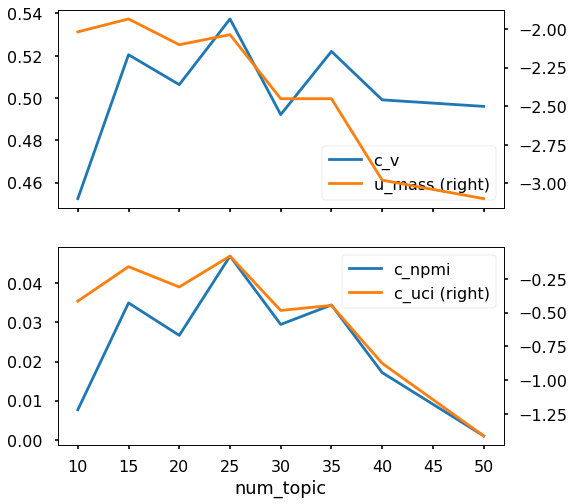

In [70]:
f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(211)
ax1 = tmfull_meta_score.plot(x='num_topic',y='c_v',ax=ax1)
ax1 = tmfull_meta_score.plot(x='num_topic', y='u_mass', ax=ax1, secondary_y=True)
ax2 = f.add_subplot(212)
ax2 = tmfull_meta_score.plot(x='num_topic', y='c_npmi', ax=ax2)
ax2 = tmfull_meta_score.plot(x='num_topic', y='c_uci',ax=ax2, secondary_y=True)

In [71]:
f.savefig('./IMG/tmfull_meta.png', format='png', bbox_inches='tight')

### Top terms for LDA model

In [72]:
best_num_topics = 25
tmfull_meta_best_model = models.LdaModel.load(
    '../src/tmfull_meta/ldamodel_nb_topics_{}'.format(best_num_topics))

2018-03-25 20:04:21,599 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_25
2018-03-25 20:04:21,600 : INFO : loading expElogbeta from ../src/tmfull_meta/ldamodel_nb_topics_25.expElogbeta.npy with mmap=None
2018-03-25 20:04:21,602 : INFO : setting ignored attribute dispatcher to None
2018-03-25 20:04:21,604 : INFO : setting ignored attribute state to None
2018-03-25 20:04:21,605 : INFO : setting ignored attribute id2word to None
2018-03-25 20:04:21,606 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_25
2018-03-25 20:04:21,607 : INFO : loading LdaModel object from ../src/tmfull_meta/ldamodel_nb_topics_25.state
2018-03-25 20:04:21,618 : INFO : loaded ../src/tmfull_meta/ldamodel_nb_topics_25.state


In [82]:
for i in range(best_num_topics):
    print('TOPIC {}'.format(i))
    eg = tmfull_meta_best_model.get_topic_terms(i, topn=15)
    for (a,b) in eg:
        print('{}\t\t{:.5f}'.format(dict_tmfull_meta[a], b))
    print('\n\n')

TOPIC 0
object		0.02948
image		0.02369
international		0.01600
publishing		0.01458
springer		0.01363
model		0.01133
conference		0.01068
class		0.01052
method		0.01040
vision		0.00905
computer		0.00882
segmentation		0.00788
computer_vision		0.00730
part		0.00721
recognition		0.00706



TOPIC 1
program		0.01166
instruction		0.01160
ieee		0.01113
performance		0.01035
compiler		0.00983
approach		0.00872
based		0.00864
algorithm		0.00863
technique		0.00819
time		0.00814
optimization		0.00778
processor		0.00767
using		0.00661
paper		0.00659
space		0.00635



TOPIC 2
speech		0.05230
model		0.01422
system		0.01400
synthesis		0.01370
speaker		0.01229
feature		0.01160
using		0.01089
acoustic		0.01068
based		0.01024
voice		0.00967
data		0.00807
recognition		0.00805
paper		0.00748
network		0.00728
speech_synthesis		0.00695



TOPIC 3
translation		0.05564
association		0.03400
machine		0.03009
computational		0.02951
linguistics		0.02679
system		0.02019
machine_translation		0.01781
association_computa

### Visualisation

In [83]:
vis_data = gensimvis.prepare(tmfull_meta_best_model, corpus_tmfull_meta, dict_tmfull_meta)

In [84]:
pyLDAvis.display(vis_data)

In [85]:
# save in html for viewing
pyLDAvis.save_html(vis_data, open('../src/tmfull_meta/res/ldavis.html', 'w'))

---
#  2012-2017 Publications

## `tmrest` : Metadata + PDF

In [28]:
dict_restricted = Dictionary.load(os.path.join(DATA_DIR,'corpora','dictionary.less.all'))

2018-03-25 13:18:01,114 : INFO : loading Dictionary object from ../../data/data_schoolofinf/corpora/dictionary.less.all
2018-03-25 13:18:01,215 : INFO : loaded ../../data/data_schoolofinf/corpora/dictionary.less.all


In [30]:
df_less_all.head(3)

year  \
pub_id                                       
18b1a861-afef-4fff-bc80-d02e05be18c4  2013   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  2012   
880944d3-26db-4003-9186-130bf3202941  2014   

                                                                            toks_metada  \
pub_id                                                                                    
18b1a861-afef-4fff-bc80-d02e05be18c4  [query, processing, data, integration, chapter...   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  [evaluation, speaker, verification, security, ...   
880944d3-26db-4003-9186-130bf3202941  [openairinterface, flexible, platform, researc...   

                                                                           toks_pdf2txt  
pub_id                                                                                   
18b1a861-afef-4fff-bc80-d02e05be18c4                                                     
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  [evaluation, speaker, verification, security, ...  
880944d3-26db-4003-9186-130bf3202941

In [37]:
df_less_all = df_combined_toks.drop(
    df_combined_toks[(df_combined_toks.year < 2012)
                     | (df_combined_toks.year > 2017)].index)
df_less_all['concat_toks'] = df_less_all.apply(
    lambda row: row.toks_metada + row.toks_pdf2txt, axis=1)
# Create a bow tagging for each publication:
df_less_all['bow'] = df_less_all['concat_toks'].apply(dict_restricted.doc2bow)

# Generate a corpus based on the tokens, which we will be using later
corpus_tmrest = df_less_all.bow.tolist()
text_tmrest = df_less_all.concat_toks.tolist()

In [33]:
tmrest_full_score = pd.read_csv('../src/tmfull_meta/scores.csv')

### Evaluation of model

In [38]:
tmrest_full_score['c_v'] = tmrest_full_score.apply(lambda row: get_score(row.num_topic, dict_restricted, texts=text_tmrest, corpus=corpus_tmrest,model_dir='../src/tmrest/', 
                                                                         coherence='c_v'),
                                                      axis=1)

2018-03-25 13:23:32,957 : INFO : loading LdaModel object from ../src/tmrest//ldamodel_nb_topics_10
2018-03-25 13:23:32,961 : INFO : loading expElogbeta from ../src/tmrest//ldamodel_nb_topics_10.expElogbeta.npy with mmap=None
2018-03-25 13:23:32,964 : INFO : setting ignored attribute dispatcher to None
2018-03-25 13:23:32,965 : INFO : setting ignored attribute id2word to None
2018-03-25 13:23:32,966 : INFO : setting ignored attribute state to None
2018-03-25 13:23:32,967 : INFO : loaded ../src/tmrest//ldamodel_nb_topics_10
2018-03-25 13:23:32,968 : INFO : loading LdaModel object from ../src/tmrest//ldamodel_nb_topics_10.state
2018-03-25 13:23:32,993 : INFO : loaded ../src/tmrest//ldamodel_nb_topics_10.state
2018-03-25 13:23:33,011 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2018-03-25 13:23:33,258 : INFO : 1 batches submitted to accumulate stats from 64 documents (227778 virtual)
2018-03-25 13:23:33,375 : IN

2018-03-25 13:26:00,085 : INFO : loaded ../src/tmrest//ldamodel_nb_topics_15.state
2018-03-25 13:26:00,121 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2018-03-25 13:26:00,314 : INFO : 1 batches submitted to accumulate stats from 64 documents (227778 virtual)
2018-03-25 13:26:00,427 : INFO : 2 batches submitted to accumulate stats from 128 documents (548738 virtual)
2018-03-25 13:26:00,534 : INFO : 3 batches submitted to accumulate stats from 192 documents (756923 virtual)
2018-03-25 13:26:00,648 : INFO : 4 batches submitted to accumulate stats from 256 documents (980207 virtual)
2018-03-25 13:26:00,777 : INFO : 5 batches submitted to accumulate stats from 320 documents (1180479 virtual)
2018-03-25 13:26:00,884 : INFO : 6 batches submitted to accumulate stats from 384 documents (1401077 virtual)
2018-03-25 13:26:09,196 : INFO : 7 batches submitted to accumulate stats from 448 documents (1619224 virtual)
2018

limit_output extension: Maximum message size of 10000 exceeded with 10104 characters

In [ ]:
tmrest_full_score['u_mass'] = tmrest_full_score.apply(lambda row: get_score(row.num_topic, dict_restricted, texts=text_tmrest, corpus=corpus_tmrest,model_dir='../src/tmrest/', 
                                                                            coherence='u_mass'),
                                                      axis=1)

In [ ]:
tmrest_full_score['c_npmi'] = tmrest_full_score.apply(lambda row: get_score(row.num_topic, dict_restricted, texts=text_tmrest, corpus=corpus_tmrest,model_dir='../src/tmrest/', 
                                                                            coherence='c_npmi'),
                                                      axis=1)

In [ ]:
tmrest_full_score['c_uci'] = tmrest_full_score.apply(lambda row: get_score(row.num_topic, dict_restricted, texts=text_tmrest, corpus=corpus_tmrest,model_dir='../src/tmrest/', 
                                                                           coherence='c_uci'),
                                                      axis=1)

### Top terms for lda model

### Visualisation

In [37]:
vis_data = gensimvis.prepare(lda_less_all, corpus_less_all, dict_restricted)

/afs/inf.ed.ac.uk/user/s14/s1450710/miniconda3/envs/infnet3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [38]:
pyLDAvis.display(vis_data)

In [40]:
# save in html for viewing
pyLDAvis.save_html(vis_data, open(os.path.join(DATA_DIR,'models','tm','tm_model3.visLDA.html'), 'w'))

## `tmrest_meta` : Metadata

In [86]:
# Constrain the dataset
df_combined_toks.drop(
    df_combined_toks[(df_combined_toks.year < 2012)
                     | (df_combined_toks.year > 2017)].index,
    inplace=True)
# Load corpora
dict_tmrest_meta = Dictionary.load(
    os.path.join(DATA_DIR, 'corpora', 'dictionary.less.meta'))
df_metadata = df_combined_toks[['year', 'toks_metada']]
# Create a bow tagging for each publication:
df_metadata['bow'] = df_metadata['toks_metada'].apply(dict_tmrest_meta.doc2bow)

# Generate a corpus based on the tokens, which we will be using later
corpus_tmrest_meta = df_metadata.bow.tolist()
text_tmrest_meta = df_metadata.toks_metada.tolist()

tmrest_meta_score = pd.read_csv(
    os.path.join('../src', 'tmrest_meta', 'scores.csv'))

2018-03-25 20:08:57,673 : INFO : loading Dictionary object from ../../data/data_schoolofinf/corpora/dictionary.less.meta
2018-03-25 20:08:57,676 : INFO : loaded ../../data/data_schoolofinf/corpora/dictionary.less.meta


### Evaluation of model

In [87]:
tmrest_meta_score['c_v'] = tmrest_meta_score.apply(lambda row: get_score(row.num_topic, dict_tmrest_meta, texts=text_tmrest_meta, corpus=corpus_tmrest_meta, model_dir='../src/tmrest_meta/',
                                                                         coherence='c_v'),
                                                      axis=1)

2018-03-25 20:09:12,153 : INFO : loading LdaModel object from ../src/tmrest_meta//ldamodel_nb_topics_10
2018-03-25 20:09:12,154 : INFO : loading expElogbeta from ../src/tmrest_meta//ldamodel_nb_topics_10.expElogbeta.npy with mmap=None
2018-03-25 20:09:12,155 : INFO : setting ignored attribute id2word to None
2018-03-25 20:09:12,156 : INFO : setting ignored attribute dispatcher to None
2018-03-25 20:09:12,157 : INFO : setting ignored attribute state to None
2018-03-25 20:09:12,157 : INFO : loaded ../src/tmrest_meta//ldamodel_nb_topics_10
2018-03-25 20:09:12,158 : INFO : loading LdaModel object from ../src/tmrest_meta//ldamodel_nb_topics_10.state
2018-03-25 20:09:12,161 : INFO : loaded ../src/tmrest_meta//ldamodel_nb_topics_10.state
2018-03-25 20:09:12,165 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2018-03-25 20:09:13,619 : INFO : 43 batches submitted to accumulate stats from 2752 documents (-37317 virtual)


2018-03-25 20:09:43,673 : INFO : serializing accumulator to return to master...
2018-03-25 20:09:43,697 : INFO : accumulator serialized
2018-03-25 20:09:43,778 : INFO : serializing accumulator to return to master...
2018-03-25 20:09:43,801 : INFO : accumulator serialized
2018-03-25 20:09:43,800 : INFO : serializing accumulator to return to master...
2018-03-25 20:09:43,820 : INFO : accumulator serialized
2018-03-25 20:09:44,069 : INFO : 3 accumulators retrieved from output queue
2018-03-25 20:09:44,383 : INFO : accumulated word occurrence stats for 48480 virtual documents
2018-03-25 20:09:45,825 : INFO : loading LdaModel object from ../src/tmrest_meta//ldamodel_nb_topics_40
2018-03-25 20:09:45,826 : INFO : loading expElogbeta from ../src/tmrest_meta//ldamodel_nb_topics_40.expElogbeta.npy with mmap=None
2018-03-25 20:09:45,829 : INFO : setting ignored attribute id2word to None
2018-03-25 20:09:45,830 : INFO : setting ignored attribute dispatcher to None
2018-03-25 20:09:45,830 : INFO : 

In [88]:
tmrest_meta_score['u_mass'] = tmrest_meta_score.apply(lambda row: get_score(row.num_topic, dict_tmrest_meta, texts=text_tmrest_meta, corpus=corpus_tmrest_meta, model_dir='../src/tmrest_meta/',
                                                                            coherence='u_mass'),
                                                      axis=1)

2018-03-25 20:10:08,778 : INFO : loading LdaModel object from ../src/tmrest_meta//ldamodel_nb_topics_10
2018-03-25 20:10:08,784 : INFO : loading expElogbeta from ../src/tmrest_meta//ldamodel_nb_topics_10.expElogbeta.npy with mmap=None
2018-03-25 20:10:08,786 : INFO : setting ignored attribute id2word to None
2018-03-25 20:10:08,787 : INFO : setting ignored attribute dispatcher to None
2018-03-25 20:10:08,788 : INFO : setting ignored attribute state to None
2018-03-25 20:10:08,789 : INFO : loaded ../src/tmrest_meta//ldamodel_nb_topics_10
2018-03-25 20:10:08,790 : INFO : loading LdaModel object from ../src/tmrest_meta//ldamodel_nb_topics_10.state
2018-03-25 20:10:08,794 : INFO : loaded ../src/tmrest_meta//ldamodel_nb_topics_10.state
2018-03-25 20:10:08,841 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-03-25 20:10:08,885 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-03-25 20:10:08,918 : INFO : CorpusAccumulator accumulated stats from 3000 do

In [89]:
tmrest_meta_score['c_npmi'] = tmrest_meta_score.apply(lambda row: get_score(row.num_topic, dict_tmrest_meta, texts=text_tmrest_meta, corpus=corpus_tmrest_meta, model_dir='../src/tmrest_meta/',
                                                                            coherence='c_npmi'),
                                                      axis=1)

2018-03-25 20:10:10,517 : INFO : loading LdaModel object from ../src/tmrest_meta//ldamodel_nb_topics_10
2018-03-25 20:10:10,518 : INFO : loading expElogbeta from ../src/tmrest_meta//ldamodel_nb_topics_10.expElogbeta.npy with mmap=None
2018-03-25 20:10:10,520 : INFO : setting ignored attribute id2word to None
2018-03-25 20:10:10,521 : INFO : setting ignored attribute dispatcher to None
2018-03-25 20:10:10,521 : INFO : setting ignored attribute state to None
2018-03-25 20:10:10,522 : INFO : loaded ../src/tmrest_meta//ldamodel_nb_topics_10
2018-03-25 20:10:10,523 : INFO : loading LdaModel object from ../src/tmrest_meta//ldamodel_nb_topics_10.state
2018-03-25 20:10:10,528 : INFO : loaded ../src/tmrest_meta//ldamodel_nb_topics_10.state
2018-03-25 20:10:10,535 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2018-03-25 20:10:10,622 : INFO : 1 batches submitted to accumulate stats from 64 documents (5664 virtual)
2018-

2018-03-25 20:10:15,743 : INFO : loaded ../src/tmrest_meta//ldamodel_nb_topics_15.state
2018-03-25 20:10:15,752 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2018-03-25 20:10:15,850 : INFO : 1 batches submitted to accumulate stats from 64 documents (5664 virtual)
2018-03-25 20:10:15,855 : INFO : 2 batches submitted to accumulate stats from 128 documents (10533 virtual)
2018-03-25 20:10:15,862 : INFO : 3 batches submitted to accumulate stats from 192 documents (15989 virtual)
2018-03-25 20:10:15,878 : INFO : 4 batches submitted to accumulate stats from 256 documents (21250 virtual)
2018-03-25 20:10:15,900 : INFO : 5 batches submitted to accumulate stats from 320 documents (26908 virtual)
2018-03-25 20:10:15,913 : INFO : 6 batches submitted to accumulate stats from 384 documents (32308 virtual)
2018-03-25 20:10:16,101 : INFO : 7 batches submitted to accumulate stats from 448 documents (37734 virtual)
2018-03-25

2018-03-25 20:10:20,979 : INFO : 4 batches submitted to accumulate stats from 256 documents (21000 virtual)
2018-03-25 20:10:20,987 : INFO : 5 batches submitted to accumulate stats from 320 documents (26529 virtual)
2018-03-25 20:10:20,994 : INFO : 6 batches submitted to accumulate stats from 384 documents (31837 virtual)
2018-03-25 20:10:21,162 : INFO : 7 batches submitted to accumulate stats from 448 documents (37364 virtual)
2018-03-25 20:10:21,263 : INFO : 8 batches submitted to accumulate stats from 512 documents (42466 virtual)
2018-03-25 20:10:21,287 : INFO : 9 batches submitted to accumulate stats from 576 documents (47807 virtual)
2018-03-25 20:10:21,362 : INFO : 10 batches submitted to accumulate stats from 640 documents (53215 virtual)
2018-03-25 20:10:21,583 : INFO : 11 batches submitted to accumulate stats from 704 documents (59102 virtual)
2018-03-25 20:10:21,599 : INFO : 12 batches submitted to accumulate stats from 768 documents (64353 virtual)
2018-03-25 20:10:21,627 :

2018-03-25 20:10:27,445 : INFO : 9 batches submitted to accumulate stats from 576 documents (47646 virtual)
2018-03-25 20:10:27,508 : INFO : 10 batches submitted to accumulate stats from 640 documents (53138 virtual)
2018-03-25 20:10:27,678 : INFO : 11 batches submitted to accumulate stats from 704 documents (59040 virtual)
2018-03-25 20:10:27,708 : INFO : 12 batches submitted to accumulate stats from 768 documents (64343 virtual)
2018-03-25 20:10:27,756 : INFO : 13 batches submitted to accumulate stats from 832 documents (70303 virtual)
2018-03-25 20:10:27,875 : INFO : 14 batches submitted to accumulate stats from 896 documents (76515 virtual)
2018-03-25 20:10:28,040 : INFO : 15 batches submitted to accumulate stats from 960 documents (81501 virtual)
2018-03-25 20:10:28,071 : INFO : 16 batches submitted to accumulate stats from 1024 documents (87326 virtual)
2018-03-25 20:10:28,080 : INFO : 17 batches submitted to accumulate stats from 1088 documents (93024 virtual)
2018-03-25 20:10:2

2018-03-25 20:10:34,040 : INFO : 14 batches submitted to accumulate stats from 896 documents (76524 virtual)
2018-03-25 20:10:34,159 : INFO : 15 batches submitted to accumulate stats from 960 documents (81510 virtual)
2018-03-25 20:10:34,194 : INFO : 16 batches submitted to accumulate stats from 1024 documents (87335 virtual)
2018-03-25 20:10:34,268 : INFO : 17 batches submitted to accumulate stats from 1088 documents (93033 virtual)
2018-03-25 20:10:34,474 : INFO : 18 batches submitted to accumulate stats from 1152 documents (98753 virtual)
2018-03-25 20:10:34,502 : INFO : 19 batches submitted to accumulate stats from 1216 documents (104357 virtual)
2018-03-25 20:10:34,553 : INFO : 20 batches submitted to accumulate stats from 1280 documents (109380 virtual)
2018-03-25 20:10:34,679 : INFO : 21 batches submitted to accumulate stats from 1344 documents (114833 virtual)
2018-03-25 20:10:34,847 : INFO : 22 batches submitted to accumulate stats from 1408 documents (119536 virtual)
2018-03-

2018-03-25 20:10:41,723 : INFO : 19 batches submitted to accumulate stats from 1216 documents (104059 virtual)
2018-03-25 20:10:42,035 : INFO : 20 batches submitted to accumulate stats from 1280 documents (109182 virtual)
2018-03-25 20:10:42,059 : INFO : 21 batches submitted to accumulate stats from 1344 documents (114494 virtual)
2018-03-25 20:10:42,147 : INFO : 22 batches submitted to accumulate stats from 1408 documents (119431 virtual)
2018-03-25 20:10:42,375 : INFO : 23 batches submitted to accumulate stats from 1472 documents (125124 virtual)
2018-03-25 20:10:42,451 : INFO : 24 batches submitted to accumulate stats from 1536 documents (130914 virtual)
2018-03-25 20:10:42,531 : INFO : 25 batches submitted to accumulate stats from 1600 documents (136736 virtual)
2018-03-25 20:10:42,691 : INFO : 26 batches submitted to accumulate stats from 1664 documents (142384 virtual)
2018-03-25 20:10:42,819 : INFO : 27 batches submitted to accumulate stats from 1728 documents (147311 virtual)
2

2018-03-25 20:10:50,159 : INFO : 23 batches submitted to accumulate stats from 1472 documents (124909 virtual)
2018-03-25 20:10:50,400 : INFO : 24 batches submitted to accumulate stats from 1536 documents (130686 virtual)
2018-03-25 20:10:50,435 : INFO : 25 batches submitted to accumulate stats from 1600 documents (136555 virtual)
2018-03-25 20:10:50,543 : INFO : 26 batches submitted to accumulate stats from 1664 documents (142139 virtual)
2018-03-25 20:10:50,763 : INFO : 27 batches submitted to accumulate stats from 1728 documents (147021 virtual)
2018-03-25 20:10:50,827 : INFO : 28 batches submitted to accumulate stats from 1792 documents (152035 virtual)
2018-03-25 20:10:50,939 : INFO : 29 batches submitted to accumulate stats from 1856 documents (157004 virtual)
2018-03-25 20:10:51,159 : INFO : 30 batches submitted to accumulate stats from 1920 documents (162463 virtual)
2018-03-25 20:10:51,291 : INFO : 31 batches submitted to accumulate stats from 1984 documents (167798 virtual)
2

2018-03-25 20:11:00,227 : INFO : 27 batches submitted to accumulate stats from 1728 documents (146798 virtual)
2018-03-25 20:11:00,387 : INFO : 28 batches submitted to accumulate stats from 1792 documents (151967 virtual)
2018-03-25 20:11:00,515 : INFO : 29 batches submitted to accumulate stats from 1856 documents (156931 virtual)
2018-03-25 20:11:00,645 : INFO : 30 batches submitted to accumulate stats from 1920 documents (162120 virtual)
2018-03-25 20:11:00,859 : INFO : 31 batches submitted to accumulate stats from 1984 documents (167657 virtual)
2018-03-25 20:11:00,959 : INFO : 32 batches submitted to accumulate stats from 2048 documents (173392 virtual)
2018-03-25 20:11:00,971 : INFO : 33 batches submitted to accumulate stats from 2112 documents (179271 virtual)
2018-03-25 20:11:01,214 : INFO : 34 batches submitted to accumulate stats from 2176 documents (184456 virtual)
2018-03-25 20:11:01,283 : INFO : 35 batches submitted to accumulate stats from 2240 documents (189712 virtual)
2

In [90]:
tmrest_meta_score['c_uci'] = tmrest_meta_score.apply(lambda row: get_score(row.num_topic, dict_tmrest_meta, texts=text_tmrest_meta, corpus=corpus_tmrest_meta, model_dir='../src/tmrest_meta/',
                                                                           coherence='c_uci'),
                                                      axis=1)

2018-03-25 20:11:07,028 : INFO : loading LdaModel object from ../src/tmrest_meta//ldamodel_nb_topics_10
2018-03-25 20:11:07,031 : INFO : loading expElogbeta from ../src/tmrest_meta//ldamodel_nb_topics_10.expElogbeta.npy with mmap=None
2018-03-25 20:11:07,033 : INFO : setting ignored attribute id2word to None
2018-03-25 20:11:07,034 : INFO : setting ignored attribute dispatcher to None
2018-03-25 20:11:07,035 : INFO : setting ignored attribute state to None
2018-03-25 20:11:07,037 : INFO : loaded ../src/tmrest_meta//ldamodel_nb_topics_10
2018-03-25 20:11:07,038 : INFO : loading LdaModel object from ../src/tmrest_meta//ldamodel_nb_topics_10.state
2018-03-25 20:11:07,043 : INFO : loaded ../src/tmrest_meta//ldamodel_nb_topics_10.state
2018-03-25 20:11:07,054 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2018-03-25 20:11:07,166 : INFO : 1 batches submitted to accumulate stats from 64 documents (5664 virtual)
2018-

2018-03-25 20:11:12,150 : INFO : loaded ../src/tmrest_meta//ldamodel_nb_topics_15.state
2018-03-25 20:11:12,163 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2018-03-25 20:11:12,256 : INFO : 1 batches submitted to accumulate stats from 64 documents (5664 virtual)
2018-03-25 20:11:12,261 : INFO : 2 batches submitted to accumulate stats from 128 documents (10533 virtual)
2018-03-25 20:11:12,270 : INFO : 3 batches submitted to accumulate stats from 192 documents (15989 virtual)
2018-03-25 20:11:12,299 : INFO : 4 batches submitted to accumulate stats from 256 documents (21250 virtual)
2018-03-25 20:11:12,315 : INFO : 5 batches submitted to accumulate stats from 320 documents (26908 virtual)
2018-03-25 20:11:12,325 : INFO : 6 batches submitted to accumulate stats from 384 documents (32308 virtual)
2018-03-25 20:11:12,491 : INFO : 7 batches submitted to accumulate stats from 448 documents (37734 virtual)
2018-03-25

2018-03-25 20:11:17,457 : INFO : 4 batches submitted to accumulate stats from 256 documents (21000 virtual)
2018-03-25 20:11:17,466 : INFO : 5 batches submitted to accumulate stats from 320 documents (26529 virtual)
2018-03-25 20:11:17,483 : INFO : 6 batches submitted to accumulate stats from 384 documents (31837 virtual)
2018-03-25 20:11:17,709 : INFO : 7 batches submitted to accumulate stats from 448 documents (37364 virtual)
2018-03-25 20:11:17,741 : INFO : 8 batches submitted to accumulate stats from 512 documents (42466 virtual)
2018-03-25 20:11:17,763 : INFO : 9 batches submitted to accumulate stats from 576 documents (47807 virtual)
2018-03-25 20:11:17,907 : INFO : 10 batches submitted to accumulate stats from 640 documents (53215 virtual)
2018-03-25 20:11:18,025 : INFO : 11 batches submitted to accumulate stats from 704 documents (59102 virtual)
2018-03-25 20:11:18,079 : INFO : 12 batches submitted to accumulate stats from 768 documents (64353 virtual)
2018-03-25 20:11:18,099 :

2018-03-25 20:11:23,486 : INFO : 9 batches submitted to accumulate stats from 576 documents (47646 virtual)
2018-03-25 20:11:23,646 : INFO : 10 batches submitted to accumulate stats from 640 documents (53138 virtual)
2018-03-25 20:11:23,679 : INFO : 11 batches submitted to accumulate stats from 704 documents (59040 virtual)
2018-03-25 20:11:23,824 : INFO : 12 batches submitted to accumulate stats from 768 documents (64343 virtual)
2018-03-25 20:11:23,877 : INFO : 13 batches submitted to accumulate stats from 832 documents (70303 virtual)
2018-03-25 20:11:23,971 : INFO : 14 batches submitted to accumulate stats from 896 documents (76515 virtual)
2018-03-25 20:11:24,122 : INFO : 15 batches submitted to accumulate stats from 960 documents (81501 virtual)
2018-03-25 20:11:24,151 : INFO : 16 batches submitted to accumulate stats from 1024 documents (87326 virtual)
2018-03-25 20:11:24,315 : INFO : 17 batches submitted to accumulate stats from 1088 documents (93024 virtual)
2018-03-25 20:11:2

2018-03-25 20:11:30,715 : INFO : 14 batches submitted to accumulate stats from 896 documents (76524 virtual)
2018-03-25 20:11:30,784 : INFO : 15 batches submitted to accumulate stats from 960 documents (81510 virtual)
2018-03-25 20:11:30,829 : INFO : 16 batches submitted to accumulate stats from 1024 documents (87335 virtual)
2018-03-25 20:11:30,974 : INFO : 17 batches submitted to accumulate stats from 1088 documents (93033 virtual)
2018-03-25 20:11:31,087 : INFO : 18 batches submitted to accumulate stats from 1152 documents (98753 virtual)
2018-03-25 20:11:31,214 : INFO : 19 batches submitted to accumulate stats from 1216 documents (104357 virtual)
2018-03-25 20:11:31,287 : INFO : 20 batches submitted to accumulate stats from 1280 documents (109380 virtual)
2018-03-25 20:11:31,423 : INFO : 21 batches submitted to accumulate stats from 1344 documents (114833 virtual)
2018-03-25 20:11:31,590 : INFO : 22 batches submitted to accumulate stats from 1408 documents (119536 virtual)
2018-03-

2018-03-25 20:11:38,199 : INFO : 19 batches submitted to accumulate stats from 1216 documents (104059 virtual)
2018-03-25 20:11:38,297 : INFO : 20 batches submitted to accumulate stats from 1280 documents (109182 virtual)
2018-03-25 20:11:38,404 : INFO : 21 batches submitted to accumulate stats from 1344 documents (114494 virtual)
2018-03-25 20:11:38,454 : INFO : 22 batches submitted to accumulate stats from 1408 documents (119431 virtual)
2018-03-25 20:11:38,664 : INFO : 23 batches submitted to accumulate stats from 1472 documents (125124 virtual)
2018-03-25 20:11:38,699 : INFO : 24 batches submitted to accumulate stats from 1536 documents (130914 virtual)
2018-03-25 20:11:38,775 : INFO : 25 batches submitted to accumulate stats from 1600 documents (136736 virtual)
2018-03-25 20:11:38,926 : INFO : 26 batches submitted to accumulate stats from 1664 documents (142384 virtual)
2018-03-25 20:11:39,019 : INFO : 27 batches submitted to accumulate stats from 1728 documents (147311 virtual)
2

2018-03-25 20:11:45,349 : INFO : 23 batches submitted to accumulate stats from 1472 documents (124909 virtual)
2018-03-25 20:11:45,420 : INFO : 24 batches submitted to accumulate stats from 1536 documents (130686 virtual)
2018-03-25 20:11:45,647 : INFO : 25 batches submitted to accumulate stats from 1600 documents (136555 virtual)
2018-03-25 20:11:45,686 : INFO : 26 batches submitted to accumulate stats from 1664 documents (142139 virtual)
2018-03-25 20:11:45,711 : INFO : 27 batches submitted to accumulate stats from 1728 documents (147021 virtual)
2018-03-25 20:11:45,963 : INFO : 28 batches submitted to accumulate stats from 1792 documents (152035 virtual)
2018-03-25 20:11:46,019 : INFO : 29 batches submitted to accumulate stats from 1856 documents (157004 virtual)
2018-03-25 20:11:46,111 : INFO : 30 batches submitted to accumulate stats from 1920 documents (162463 virtual)
2018-03-25 20:11:46,265 : INFO : 31 batches submitted to accumulate stats from 1984 documents (167798 virtual)
2

2018-03-25 20:11:53,920 : INFO : 27 batches submitted to accumulate stats from 1728 documents (146798 virtual)
2018-03-25 20:11:53,930 : INFO : 28 batches submitted to accumulate stats from 1792 documents (151967 virtual)
2018-03-25 20:11:54,023 : INFO : 29 batches submitted to accumulate stats from 1856 documents (156931 virtual)
2018-03-25 20:11:54,192 : INFO : 30 batches submitted to accumulate stats from 1920 documents (162120 virtual)
2018-03-25 20:11:54,355 : INFO : 31 batches submitted to accumulate stats from 1984 documents (167657 virtual)
2018-03-25 20:11:54,467 : INFO : 32 batches submitted to accumulate stats from 2048 documents (173392 virtual)
2018-03-25 20:11:54,579 : INFO : 33 batches submitted to accumulate stats from 2112 documents (179271 virtual)
2018-03-25 20:11:54,767 : INFO : 34 batches submitted to accumulate stats from 2176 documents (184456 virtual)
2018-03-25 20:11:54,871 : INFO : 35 batches submitted to accumulate stats from 2240 documents (189712 virtual)
2

#### Best number of topics

In [91]:
tmrest_meta_score

num_topic       c_v    u_mass    c_npmi     c_uci
0         10  0.501705 -1.769237  0.027261 -0.236365
1         15  0.502481 -1.930897  0.028490 -0.319394
2         20  0.483524 -2.396129  0.013157 -0.917338
3         25  0.490368 -2.465390  0.003185 -1.147954
4         30  0.508262 -2.528586  0.019890 -0.888930
5         35  0.481175 -2.906611 -0.003609 -1.458714
6         40  0.496624 -2.696125  0.002633 -1.337677
7         50  0.468453 -3.321530 -0.022470 -2.097948

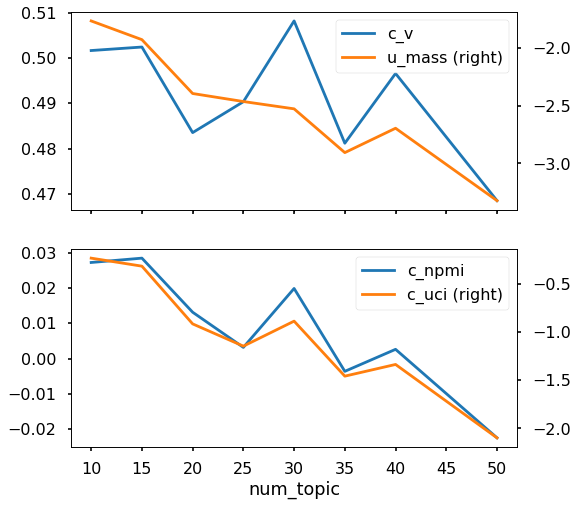

In [92]:
f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(211)
ax1 = tmrest_meta_score.plot(x='num_topic',y='c_v',ax=ax1)
ax1 = tmrest_meta_score.plot(x='num_topic', y='u_mass', ax=ax1, secondary_y=True)
ax2 = f.add_subplot(212)
ax2 = tmrest_meta_score.plot(x='num_topic', y='c_npmi', ax=ax2)
ax2 = tmrest_meta_score.plot(x='num_topic', y='c_uci',ax=ax2, secondary_y=True)

# df = tmrest_meta_score
# ax = tmrest_meta_score.plot(x='num_topic')
# best = df.c_v.argmax()
# ax.scatter(x=df.num_topic.iloc[best], y=df.iloc[best].c_v, c='g', marker='*', s=150)

In [94]:
f.savefig('./IMG/tmrest_meta.png', fomat='png', bbox_inches='tight')

### Top terms for lda model:

In [93]:
best_num_topics = 30
tmrest_meta_best_model = models.LdaModel.load('../src/tmrest_meta/ldamodel_nb_topics_{}'.format(best_num_topics))

2018-03-25 20:13:06,887 : INFO : loading LdaModel object from ../src/tmrest_meta/ldamodel_nb_topics_30
2018-03-25 20:13:06,889 : INFO : loading expElogbeta from ../src/tmrest_meta/ldamodel_nb_topics_30.expElogbeta.npy with mmap=None
2018-03-25 20:13:06,891 : INFO : setting ignored attribute id2word to None
2018-03-25 20:13:06,891 : INFO : setting ignored attribute dispatcher to None
2018-03-25 20:13:06,893 : INFO : setting ignored attribute state to None
2018-03-25 20:13:06,894 : INFO : loaded ../src/tmrest_meta/ldamodel_nb_topics_30
2018-03-25 20:13:06,895 : INFO : loading LdaModel object from ../src/tmrest_meta/ldamodel_nb_topics_30.state
2018-03-25 20:13:06,905 : INFO : loaded ../src/tmrest_meta/ldamodel_nb_topics_30.state


In [95]:
for i in range(best_num_topics):
    print('TOPIC {}'.format(i))
    eg = tmrest_meta_best_model.get_topic_terms(i, topn=15)
    for (a,b) in eg:
        print('{}\t\t{:.5f}'.format(dict_tmrest_meta[a], b))
    print('\n\n')

TOPIC 0
system		0.02466
programming		0.02060
level		0.01960
high		0.01720
opencl		0.01625
gpus		0.01523
parallel		0.01413
application		0.01267
data		0.01247
type		0.01168
implementation		0.01079
unit		0.01040
high_level		0.00958
approach		0.00950
accelerator		0.00911



TOPIC 1
problem		0.01933
user		0.01819
search		0.01638
retrieval		0.01370
distribution		0.01362
algorithm		0.01164
result		0.01132
transducer		0.01084
exploratory		0.00816
given		0.00812
set		0.00782
relevance		0.00735
query		0.00638
show		0.00606
information		0.00587



TOPIC 2
query		0.04942
data		0.02290
database		0.02137
tree		0.01743
game		0.01566
class		0.01244
answer		0.00967
problem		0.00873
graph		0.00859
complexity		0.00798
show		0.00753
answering		0.00729
value		0.00688
one		0.00670
regular		0.00656



TOPIC 3
graph		0.05727
pattern		0.02301
data		0.02066
algorithm		0.01534
matching		0.01381
view		0.01000
problem		0.00967
analysis		0.00926
scene		0.00815
using		0.00814
based		0.00809
show		0.00774
real		0.007

### Visualisation

In [96]:
vis_data = gensimvis.prepare(tmrest_meta_best_model, corpus_tmrest_meta, dict_tmrest_meta)

In [97]:
pyLDAvis.display(vis_data)

In [100]:
# save in html for viewing
pyLDAvis.save_html(vis_data, open('../src/tmrest_meta/res/ldavis.html', 'w'))

--
# Topic modelling using DBLP

In [6]:
DATA_DIRIR = '../../data/data_dblp'

In [7]:
dblp_toks = pd.read_pickle(os.path.join(DATA_DIR,'toks','toks.dblp.pkl'))

In [9]:
dict_dblp = Dictionary.load(os.path.join(DATA_DIR, 'corpora', 'dictionary.dblp.1997-2017'))

2018-02-06 12:38:44,331 : INFO : loading Dictionary object from ../../data/data_dblp/corpora/dictionary.dblp.1997-2017
2018-02-06 12:38:44,399 : INFO : loaded ../../data/data_dblp/corpora/dictionary.dblp.1997-2017


In [10]:
# convert dblp_toks to BOW:
dblp_toks['bow'] = dblp_toks['toks'].apply(dict_dblp.doc2bow)

In [11]:
corpus_dblp = dblp_toks.bow.tolist()

In [12]:
# Parameters FOR LDA:
num_topics = 100 ### RANDOMLY 100 topics
corpus = corpus_dblp
tmp = dict_dblp[0]
id2word = dict_dblp.id2token

In [ ]:
# This is the fullpub LDA model.
lda_dblp = models.ldamodel.LdaModel(
    minimum_probability=.01,
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    eta='auto',
    alpha='auto',
    num_topics=num_topics,
    iterations=iterations,
    passes=passes,
    update_every=update_every,
    eval_every=eval_every,
    random_state=rng)

---
# ARCHIVE BELOW:

# Model 1: Full Series of Publications

From `preprocess_pubs.ipynb` in [infnet-scrapper](../infnet-scrapper/notebooks/preprocess_pubs.ipynb), we generate tokens for our publications.

Now, we use these tokens to create a dictionary, corpus, and topic models for each of the documents

In [9]:
combine_toks = lambda row: row.summary_toks + row.bigram_toks + row.trigram_toks

In [10]:
pub_toks['combined_toks'] = pub_toks.apply(combine_toks, axis=1)

In [11]:
print((pub_toks.iloc[0].combined_toks))

['ballooning', 'stability', 'analysis', 'jet', 'hmode', 'discharge', 'previous', 'study', 'stability', 'large', 'aspect', 'ratio', 'model', 'equilibrium', 'ideal', 'mhd', 'ballooning', 'mode', 'shown', 'across', 'bulk', 'plasma', 'exist', 'two', 'marginally', 'stable', 'value', 'pressure', 'gradient', 'parameter', 'define', 'unstable', 'zone', 'separate', 'first', 'small', 'stable', 'region', 'second', 'large', 'stable', 'region', 'close', 'separatrix', 'however', 'first', 'second', 'region', 'coalesce', 'surface', 'averaged', 'current', 'density', 'exceeds', 'critical', 'value', 'plasma', 'region', 'stable', 'ballooning', 'mode', 'value', 'pressure', 'gradient', 'paper', 'extend', 'result', 'jet', 'mode', 'equilibrium', 'using', 'finite', 'aspect', 'ratio', 'ballooning', 'formalism', 'ass', 'relevance', 'ideal', 'ballooning', 'stability', 'discharge', 'particular', 'analyse', 'shot', 'time', 'sec', 'phase', 'proceeding', '16th', 'european', 'conference', 'controlled', 'fusion', 'plasm

In [12]:
docs = pub_toks.combined_toks.tolist()

# Create the dictionary mapping:
dictionary = Dictionary(docs)

# ignore words that appear in less than 10 documents or more than 50% documents
dictionary.filter_extremes(no_below=10, no_above=0.5) 
dictionary.compactify()

# Create a bow tagging for each publication:
bowified = lambda row: dictionary.doc2bow(row.combined_toks)
pub_toks['bow'] = pub_toks.apply(bowified, axis=1)

# Generate a corpus based on the tokens, which we will be using later
corpus = pub_toks.bow.tolist()

2018-01-20 00:14:58,894 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-01-20 00:14:59,685 : INFO : built Dictionary(27911 unique tokens: ['ballooning', 'stability', 'analysis', 'jet', 'hmode']...) from 8867 documents (total 771590 corpus positions)
2018-01-20 00:14:59,727 : INFO : discarding 21452 tokens: [('ballooning', 9), ('jet', 8), ('hmode', 4), ('discharge', 8), ('mhd', 6), ('marginally', 5), ('zone', 9), ('separatrix', 5), ('coalesce', 2), ('sec', 9)]...
2018-01-20 00:14:59,728 : INFO : keeping 6459 tokens which were in no less than 10 and no more than 4433 (=50.0%) documents
2018-01-20 00:14:59,740 : INFO : resulting dictionary: Dictionary(6459 unique tokens: ['stability', 'analysis', 'previous', 'study', 'large']...)


In [13]:
print(('Number of unique tokens:', len(dictionary)))
print(('Number of documents: ', len(corpus)))

('Number of unique tokens:', 6459)
('Number of documents: ', 8867)


In [14]:
pub_toks.head(2)

year  \
pub_id                                       
400818dc-63af-4a26-80c5-906f98e1f8ab  1989   
18b1a861-afef-4fff-bc80-d02e05be18c4  2013   

                                                                                  title  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  ballooning stability analysis of jet hmode dis...   
18b1a861-afef-4fff-bc80-d02e05be18c4               query processing in data integration   

                                                                               abstract  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  previous studies of the stability of a large a...   
18b1a861-afef-4fff-bc80-d02e05be18c4  in this chapter we illustrate the main techniq...   

                                                                           publications  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab   proceedings 16th european conference on contr...   
18b1a861-afef-4fff-bc80-d02e05be18c4  data exchange, integration, and streams,dagstu...   

                                                                                summary  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  ballooning stability analysis of jet hmode dis...   
18b1a861-afef-4fff-bc80-d02e05be18c4  query processing in data integration. in this ...   

                                                                           summary_toks  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  [ballooning, stability, analysis, jet, hmode, ...   
18b1a861-afef-4fff-bc80-d02e05be18c4  [query, processing, data, integration, chapter...   

                                                                            bigram_toks  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab                              [european_conference]   
18b1a861-afef-4fff-bc80-d02e05be18c4  [query_answering, integrity_constraint, semist...   

                                     trigram_toks  \
pub_id                                              
400818dc-63af-4a26-80c5-906f98e1f8ab           []   
18b1a861-afef-4fff-bc80-d02e05be18c4           []   

                                                                          combined_toks  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  [ballooning, stability, analysis, jet, hmode, ...   
18b1a861-afef-4fff-bc80-d02e05be18c4  [query, processing, data, integration, chapter...   

                                                                                    bow  
pub_id                                                                                   
400818dc-63af-4a26-80c5-906f98e1f8ab  [(0, 3), (1, 1), (2, 1), (3, 1), (4, 2), (5, 2...  
18b1a861-afef-4fff-bc80-d02e05be18c4  [(7, 1), (25, 1), (28, 1), (58, 8), (59, 4), (...

In [15]:
# Save the dictionary:
dictionary.save('../data/fullpub/dictionary_fullpub.pkl', pickle_protocol=-1)
# save the pub_toks:
pub_toks.to_pickle('../data/fullpub/pub_toks_wBOW_fullpub.pkl')
# save the corpus:
pkl.dump(corpus, open('../data/fullpub/corpus_fullpub.pkl', 'wb'), -1)

2018-01-20 00:15:09,085 : INFO : saving Dictionary object under ../data/fullpub/dictionary_fullpub.pkl, separately None
2018-01-20 00:15:09,089 : INFO : saved ../data/fullpub/dictionary_fullpub.pkl


## LDA Modelling:

In [30]:
num_topics = 50
passes = 30  # total number of times the corpus is seen
iterations = 1000  # how many times each document is seen
chunksize = 2000  # how many documents each mini-batch
update_every = 0  # Batch learning
eval_every = None

In [25]:
tmp = dictionary[0]
id2word = dictionary.id2token

In [31]:
# This is the fullpub LDA model.
lda = models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    eta='auto',
    alpha='auto',
    num_topics=num_topics,
    iterations=iterations,
    passes=passes,
    update_every=update_every,
    eval_every=eval_every,
    random_state=rng)

2018-01-20 00:58:03,674 : INFO : using autotuned alpha, starting with [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
2018-01-20 00:58:03,678 : INFO : using serial LDA version on this node
2018-01-20 00:58:05,807 : INFO : running batch LDA training, 50 topics, 30 passes over the supplied corpus of 8867 documents, updating model once every 8867 documents, evaluating perplexity every 0 documents, iterating 1000x with a convergence threshold of 0.001000
2018-01-20 00:58:05,808 : INFO : PROGRESS: pass 0, at document #2000/8867
2018-01-20 00:58:31,693 : INFO : optimized alpha [0.018586102399558112, 0.0187478064484662, 0.018182244123782196, 0.019022041470034706, 0.018431945813717533, 0.018652079237067062, 0.018422598341878916, 0.01862123141538

2018-01-20 01:00:10,163 : INFO : PROGRESS: pass 1, at document #4000/8867
2018-01-20 01:00:18,805 : INFO : optimized alpha [0.015084156711368592, 0.014420950366857806, 0.012928554051477208, 0.01552624934890383, 0.013223300927790348, 0.013983101676269562, 0.013430127555943716, 0.014203994616282745, 0.013187855082758439, 0.015131935127142514, 0.014071688631184243, 0.014304362735601268, 0.013656052442934181, 0.012969846868467753, 0.01317679661834914, 0.015359809063171876, 0.013667208158158169, 0.015108033531941173, 0.014098878668482044, 0.013040156499565914, 0.013820596002132656, 0.014047863128428116, 0.014279675287830522, 0.013768674215825852, 0.013540687303029415, 0.014157430655364926, 0.014674526846332022, 0.014169873856300679, 0.012867757295635921, 0.013141881842583573, 0.014678939757465025, 0.014846112150344504, 0.013102964149121394, 0.015184116121036319, 0.013293205174507964, 0.013170214355695879, 0.013263643466366794, 0.015360998503201216, 0.013926490925346542, 0.013908358014486118

2018-01-20 01:00:59,129 : INFO : PROGRESS: pass 2, at document #6000/8867
2018-01-20 01:01:06,720 : INFO : optimized alpha [0.015751058978676312, 0.013308520881177224, 0.011712420354657438, 0.014975562283059404, 0.012202390252266456, 0.013538825644625602, 0.012327261783284907, 0.013162337896646809, 0.012147338252954398, 0.014223031625062964, 0.01342227498553995, 0.013387689517877248, 0.012912239884303905, 0.012231027353929716, 0.012153125015478985, 0.014888272655619508, 0.012578128320975117, 0.014155945504005138, 0.01320008484769074, 0.011943720799305843, 0.012675134474237905, 0.013569326680290289, 0.013182501509334249, 0.012975528467969845, 0.012554268568237076, 0.013181881531162488, 0.013563411511282561, 0.013264958517330156, 0.011756890415304713, 0.012231749326289985, 0.01359711180984024, 0.014172538438189162, 0.01204535369712015, 0.014489189519061547, 0.012105889407789583, 0.012175645726197759, 0.012135649241793759, 0.015043657833569854, 0.01276947081995853, 0.012815930938533362, 0

2018-01-20 01:01:45,393 : INFO : PROGRESS: pass 3, at document #8000/8867
2018-01-20 01:01:53,880 : INFO : optimized alpha [0.016964387229504517, 0.012490253307095077, 0.010954976399617294, 0.014563892739011189, 0.011664895512170335, 0.013734980541645941, 0.011579182936443956, 0.012430159191958615, 0.011408123548435588, 0.013558563171894796, 0.013149777829330129, 0.012677379615677498, 0.012512109553553152, 0.0120438197827496, 0.011567245358492519, 0.014642146569086313, 0.011750634186491828, 0.013443292121889886, 0.012722756253506185, 0.011272864069340253, 0.011940685453515591, 0.013697616115674091, 0.012350425410273999, 0.012572911758171211, 0.011978507693979786, 0.012523452715976428, 0.012748756119293707, 0.012738202759850293, 0.01103936257431142, 0.011831651432460155, 0.012831637476024593, 0.013835278288405551, 0.011340361220432213, 0.014116023508220197, 0.011270209698458598, 0.011578053649559297, 0.011447613460725179, 0.015249681649988986, 0.011984358647175815, 0.012041829324402986,

2018-01-20 01:02:26,948 : INFO : PROGRESS: pass 4, at document #8867/8867
2018-01-20 01:02:30,080 : INFO : optimized alpha [0.01839981873177414, 0.011978381028353503, 0.010495322032869918, 0.014184251769139662, 0.011356724893937936, 0.014419959894267784, 0.011087081701865386, 0.011862643989013988, 0.01090170013693809, 0.013102489808068678, 0.013107300676828292, 0.012216481861228522, 0.012383295214959362, 0.012062446587573241, 0.011195633289757763, 0.014651505384366287, 0.011174908781765936, 0.012879195177728139, 0.012375134994863384, 0.010854186495991154, 0.011535539509476851, 0.014098621188764354, 0.011818618437739336, 0.012447591409802212, 0.011564407310767025, 0.012106544855230831, 0.012201340377526204, 0.012610287229528056, 0.01050130701335395, 0.011835496056713361, 0.012237162848349237, 0.013680791185666492, 0.01079351693912965, 0.013959179998447526, 0.010730427089229005, 0.011162028444134478, 0.010995580567566667, 0.015785324089184628, 0.011462245943204673, 0.011532286167091609, 

2018-01-20 01:03:02,235 : INFO : topic #48 (0.010): 0.015*"configuration" + 0.008*"system" + 0.007*"grid" + 0.007*"approach" + 0.007*"instruction" + 0.006*"eye" + 0.005*"embedded" + 0.005*"set" + 0.005*"simulation" + 0.005*"two"
2018-01-20 01:03:02,236 : INFO : topic #47 (0.010): 0.011*"language" + 0.008*"ontology" + 0.007*"model" + 0.007*"arabic" + 0.006*"query" + 0.006*"workshop" + 0.006*"proceeding" + 0.005*"network" + 0.005*"ceur" + 0.005*"latency"
2018-01-20 01:03:02,238 : INFO : topic #44 (0.015): 0.019*"model" + 0.015*"language" + 0.010*"computational" + 0.009*"linguistics" + 0.008*"association" + 0.008*"using" + 0.007*"word" + 0.007*"method" + 0.007*"proceeding" + 0.007*"association_computational"
2018-01-20 01:03:02,239 : INFO : topic #37 (0.016): 0.031*"model" + 0.015*"neural" + 0.010*"data" + 0.010*"system" + 0.009*"learning" + 0.009*"network" + 0.007*"using" + 0.006*"based" + 0.005*"image" + 0.005*"show"
2018-01-20 01:03:02,240 : INFO : topic #0 (0.020): 0.041*"springer" + 

2018-01-20 01:03:31,202 : INFO : topic #0 (0.021): 0.044*"springer" + 0.042*"berlin" + 0.041*"heidelberg" + 0.023*"berlin_heidelberg" + 0.017*"springer_berlin" + 0.015*"international" + 0.013*"heidelberg_springer" + 0.012*"proceeding" + 0.012*"conference" + 0.008*"model"
2018-01-20 01:03:31,205 : INFO : topic diff=1.015123, rho=0.295740
2018-01-20 01:03:31,493 : INFO : PROGRESS: pass 7, at document #2000/8867
2018-01-20 01:03:37,815 : INFO : optimized alpha [0.020759358010078739, 0.011702231808962141, 0.010078349273297274, 0.013749367033806924, 0.011448315297690597, 0.016361749961536286, 0.010558067032627082, 0.011236646381238079, 0.010395603959744501, 0.012701054939861596, 0.013528478389412126, 0.011575372425358827, 0.012584429624681917, 0.012417012992927644, 0.011027169413053447, 0.014865523940833427, 0.010554198810427644, 0.012205271220830901, 0.012273510196107371, 0.010453439743618684, 0.01113530807622963, 0.014987069266971203, 0.011208506389959502, 0.012506484994405582, 0.01137935

2018-01-20 01:04:06,668 : INFO : PROGRESS: pass 8, at document #4000/8867
2018-01-20 01:04:12,818 : INFO : optimized alpha [0.021986559990129384, 0.011772232921105939, 0.010017106138591839, 0.013635333829917487, 0.011611969226939247, 0.017425836179871129, 0.010348873623156616, 0.011017913422001991, 0.010262072927795891, 0.012658759188952441, 0.013852810419638047, 0.011313217274014896, 0.012827678551612428, 0.012649575446889313, 0.01106282144299389, 0.014935710254906233, 0.01035242228194224, 0.012029578624165788, 0.012377132340769039, 0.010373191808682364, 0.011082731340056039, 0.015543360072094522, 0.011070075122449393, 0.012670914497139975, 0.011405693284988675, 0.011811326910483153, 0.011454928880647993, 0.013157387378315667, 0.0096784228980091608, 0.012686697958524435, 0.011336411736069868, 0.014198392411410998, 0.0099615692951653869, 0.013691061117086786, 0.0099724184892296397, 0.010511847487756036, 0.010456508923661898, 0.017782786619118335, 0.010773054055676436, 0.011014668784118

2018-01-20 01:04:40,787 : INFO : PROGRESS: pass 9, at document #6000/8867
2018-01-20 01:04:46,346 : INFO : optimized alpha [0.023195061216615957, 0.011970435293809601, 0.010034251440063674, 0.013596062123739594, 0.011823995923029008, 0.018530744500835302, 0.010206910126310023, 0.010842341112189454, 0.010190388918085335, 0.012705455253816941, 0.014250020492079948, 0.011169639264540374, 0.013134162087404875, 0.012942050297681144, 0.011124630869924252, 0.015093109095889259, 0.010189626660626198, 0.011910779640694523, 0.012575218002617109, 0.01036590507330345, 0.011090935922998278, 0.016061036355128313, 0.010986199529579774, 0.012883193409199299, 0.011477316399702115, 0.011835634780761365, 0.011379628076870537, 0.013503546961909038, 0.0095327696870023144, 0.013117977487927774, 0.011198086770638107, 0.014517977170335986, 0.0097794043518044729, 0.013671903263351855, 0.0098648278644097604, 0.010409779545627244, 0.010432061882795598, 0.018508571234501444, 0.010660941254408389, 0.01103597150161

2018-01-20 01:05:12,173 : INFO : PROGRESS: pass 10, at document #8000/8867
2018-01-20 01:05:17,874 : INFO : optimized alpha [0.02423549790252634, 0.012227765246826731, 0.010100190948929848, 0.013560738529112906, 0.012077821214527872, 0.019569183942009474, 0.010133557743205667, 0.010704418643122039, 0.010187465935898017, 0.012752249384754446, 0.014727358963173063, 0.011055825341624899, 0.01343098785825602, 0.013229586788759466, 0.011269735752337966, 0.015294529455354495, 0.01007848548241325, 0.011820018273093298, 0.012842499221501366, 0.010380062538126629, 0.011163155835718797, 0.016591062184008489, 0.010958631192226865, 0.013119102895230307, 0.011563909110205826, 0.011889949279306505, 0.011409899802558684, 0.013856779351140134, 0.0094620694483127602, 0.013578910190453137, 0.011126198353957222, 0.015019055465274187, 0.0096478839007665407, 0.013677729127347108, 0.0098042226830678952, 0.01035641639710639, 0.010432252773674358, 0.019318944019447632, 0.010612737114935539, 0.0111870026024274

2018-01-20 01:05:43,208 : INFO : PROGRESS: pass 11, at document #8867/8867
2018-01-20 01:05:45,675 : INFO : optimized alpha [0.025337491244012907, 0.012606027640624027, 0.010224513857608666, 0.013538369568641228, 0.012312213300049377, 0.020475509178137636, 0.010103337134928283, 0.010598072968250135, 0.010187545839016564, 0.012872424239502122, 0.015222491030555415, 0.010995743575935697, 0.013735778620305675, 0.013471382103063406, 0.011371792308823776, 0.0155058440165101, 0.009997272622452081, 0.011752608052506129, 0.01311183588960275, 0.01040650145568706, 0.011320447742489765, 0.017020842497806929, 0.011009467877682333, 0.013457326645440342, 0.011609972528644227, 0.012005522510392618, 0.011496816854415774, 0.014236019199257701, 0.0093969281813429655, 0.014042844877107646, 0.011052034808463779, 0.015496807750505586, 0.0095301262685367136, 0.013742668732701127, 0.0098396117390680288, 0.01030660864901152, 0.010454258827482349, 0.020141745284596755, 0.010645057388542458, 0.01145595684882722

2018-01-20 01:06:10,441 : INFO : topic #48 (0.008): 0.029*"configuration" + 0.012*"instruction" + 0.011*"simulation" + 0.010*"simulator" + 0.009*"grid" + 0.008*"system" + 0.008*"space" + 0.008*"approach" + 0.008*"embedded" + 0.007*"set"
2018-01-20 01:06:10,442 : INFO : topic #47 (0.009): 0.025*"ontology" + 0.012*"workshop" + 0.012*"ceur" + 0.011*"language" + 0.009*"proceeding" + 0.008*"arabic" + 0.007*"ceur_workshop" + 0.007*"latency" + 0.006*"w" + 0.006*"measurement"
2018-01-20 01:06:10,443 : INFO : topic #37 (0.021): 0.037*"model" + 0.019*"neural" + 0.012*"data" + 0.011*"network" + 0.011*"learning" + 0.008*"system" + 0.007*"using" + 0.007*"bayesian" + 0.006*"gaussian" + 0.006*"parameter"
2018-01-20 01:06:10,444 : INFO : topic #5 (0.021): 0.021*"system" + 0.020*"web" + 0.016*"service" + 0.010*"user" + 0.010*"acm" + 0.009*"application" + 0.008*"design" + 0.008*"new" + 0.007*"paper" + 0.007*"project"
2018-01-20 01:06:10,445 : INFO : topic #0 (0.026): 0.059*"springer" + 0.051*"berlin" + 

2018-01-20 01:06:35,256 : INFO : topic #0 (0.027): 0.061*"springer" + 0.052*"berlin" + 0.050*"heidelberg" + 0.029*"berlin_heidelberg" + 0.021*"springer_berlin" + 0.020*"international" + 0.016*"proceeding" + 0.016*"conference" + 0.015*"heidelberg_springer" + 0.009*"verlag"
2018-01-20 01:06:35,258 : INFO : topic diff=0.384039, rho=0.232914
2018-01-20 01:06:35,462 : INFO : PROGRESS: pass 14, at document #2000/8867
2018-01-20 01:06:40,703 : INFO : optimized alpha [0.026952484017770419, 0.013408118782595315, 0.010503603747251563, 0.01359011277839862, 0.012882588968384751, 0.022131802070488017, 0.010090410735043872, 0.010586396362668086, 0.01026344704084519, 0.013147798198551454, 0.016233621641178805, 0.010933347233022906, 0.014300741227953901, 0.013876636560838901, 0.011677120969002005, 0.015982332863452051, 0.0099725099321811075, 0.011719486968441328, 0.013735436894305193, 0.010551034703707177, 0.011564519524136048, 0.017724040391871969, 0.011179374771032759, 0.01399751715388175, 0.0119203

2018-01-20 01:07:04,523 : INFO : PROGRESS: pass 15, at document #4000/8867
2018-01-20 01:07:09,699 : INFO : optimized alpha [0.027782124024968095, 0.013884983280677042, 0.010702229563497962, 0.013680607369348841, 0.01317932298030239, 0.022938934577657527, 0.010090798922021872, 0.010616005578763341, 0.010334258948812521, 0.013359240812391671, 0.016737506014236882, 0.010917453167054197, 0.014621291831649726, 0.014064592488161729, 0.011871377339499027, 0.01620808553223637, 0.0099860796384625885, 0.011758670962148506, 0.014121852824098538, 0.01063351332664287, 0.011738554227799803, 0.018095833204099611, 0.011305785757960001, 0.014356638267239803, 0.012134188724950394, 0.012471398243950872, 0.011811658102319357, 0.015407142443585117, 0.0093788028832231893, 0.015373749794092796, 0.011050034452983557, 0.017333585642710099, 0.0093860489830037939, 0.013897732363117629, 0.0099771518462938458, 0.010315624873474668, 0.010716837126970502, 0.02218385519658941, 0.010862928197275247, 0.012427737337495

2018-01-20 01:07:33,263 : INFO : PROGRESS: pass 16, at document #6000/8867
2018-01-20 01:07:38,508 : INFO : optimized alpha [0.028614608176839206, 0.014404666672427274, 0.010889659067295766, 0.013781210128721107, 0.013482403132608555, 0.023787586574732619, 0.010120539514738385, 0.010643677253678886, 0.010429434158205214, 0.013590425486282228, 0.017159882991310868, 0.010928871545473319, 0.014938300498098623, 0.014261922778618388, 0.012068086931014188, 0.016510218813455158, 0.010007111314676447, 0.011822807515279456, 0.014523764476269081, 0.010745432831535808, 0.011919872645357977, 0.018437510624277408, 0.011430172485857249, 0.014706585870192895, 0.012364998935613913, 0.012654271899974767, 0.011946280543441108, 0.015871153478511781, 0.0094205666765680342, 0.015846641370778868, 0.011094789349616449, 0.017995373442372335, 0.009385109572309893, 0.013974608099703963, 0.010065577562330109, 0.010343213300959305, 0.010794916816296471, 0.022824964050064525, 0.010966204135934439, 0.01273577204073

2018-01-20 01:08:02,081 : INFO : PROGRESS: pass 17, at document #8000/8867
2018-01-20 01:08:07,274 : INFO : optimized alpha [0.029333765653353539, 0.014931441291408491, 0.011063397027131099, 0.013888564744327847, 0.013799335019736634, 0.024541888247133999, 0.010185939185379602, 0.010673194483328289, 0.010551897405979286, 0.013795827595223865, 0.017700001345227895, 0.010926242399832508, 0.015233503199960531, 0.014482306133305808, 0.012321636032501545, 0.016754841778599677, 0.010049845205738196, 0.011900258298661703, 0.014913636775244678, 0.010866340364299133, 0.012134252044676986, 0.018851994624099769, 0.011576922928571693, 0.015079681926010719, 0.012595365284325878, 0.012845990206406085, 0.012144715982868167, 0.01626356885135366, 0.0094923482778546484, 0.016311784674760164, 0.011176253049817066, 0.018755877682832885, 0.0093950126372913164, 0.014054363605318884, 0.010169161943558823, 0.010410734543704085, 0.010873673632204013, 0.02347144309721607, 0.011090250638221515, 0.013065333908115

2018-01-20 01:08:30,927 : INFO : PROGRESS: pass 18, at document #8867/8867
2018-01-20 01:08:33,269 : INFO : optimized alpha [0.030105525540123444, 0.015560137499939496, 0.011255323603799034, 0.013963155599281954, 0.01405839485323376, 0.025204002187564387, 0.010270854420970178, 0.010714941997035451, 0.010656260070339563, 0.014048633396357995, 0.018221504485487271, 0.010958223567605957, 0.015512206243401598, 0.014680031172650035, 0.012527983139534135, 0.017004192883164123, 0.010095855913076646, 0.011997485527408197, 0.01531657604127493, 0.010957633224271972, 0.012374520077276758, 0.019172931185142274, 0.011741467915115072, 0.015551235294436057, 0.012786048618102114, 0.013070289497717689, 0.012350495246709288, 0.016618736371746299, 0.0095582664800259905, 0.016710905383916438, 0.01122657330144749, 0.019459998577510032, 0.0094077289294357772, 0.014150918893933174, 0.010340361379551138, 0.010461604334727819, 0.010968614689685808, 0.02412093098694185, 0.011258445492470411, 0.01340669695459644

2018-01-20 01:08:57,104 : INFO : topic #47 (0.009): 0.044*"ontology" + 0.016*"workshop" + 0.013*"ceur" + 0.012*"proceeding" + 0.010*"language" + 0.008*"arabic" + 0.008*"semantic" + 0.007*"ceur_workshop" + 0.007*"w" + 0.007*"semantic_web"
2018-01-20 01:08:57,105 : INFO : topic #48 (0.009): 0.032*"configuration" + 0.019*"instruction" + 0.017*"simulation" + 0.014*"simulator" + 0.011*"space" + 0.009*"set" + 0.009*"grid" + 0.008*"instruction_set" + 0.008*"system" + 0.008*"embedded"
2018-01-20 01:08:57,106 : INFO : topic #37 (0.025): 0.039*"model" + 0.021*"neural" + 0.014*"data" + 0.012*"learning" + 0.012*"network" + 0.008*"parameter" + 0.008*"bayesian" + 0.007*"system" + 0.007*"using" + 0.007*"gaussian"
2018-01-20 01:08:57,107 : INFO : topic #5 (0.026): 0.023*"system" + 0.020*"web" + 0.016*"service" + 0.009*"user" + 0.009*"application" + 0.008*"technology" + 0.008*"design" + 0.008*"project" + 0.008*"paper" + 0.007*"research"
2018-01-20 01:08:57,108 : INFO : topic #0 (0.031): 0.067*"springer

2018-01-20 01:09:19,634 : INFO : topic #0 (0.031): 0.068*"springer" + 0.055*"berlin" + 0.053*"heidelberg" + 0.031*"berlin_heidelberg" + 0.023*"international" + 0.022*"springer_berlin" + 0.018*"proceeding" + 0.018*"conference" + 0.016*"heidelberg_springer" + 0.010*"verlag"
2018-01-20 01:09:19,637 : INFO : topic diff=0.162754, rho=0.198288
2018-01-20 01:09:19,812 : INFO : PROGRESS: pass 21, at document #2000/8867
2018-01-20 01:09:24,921 : INFO : optimized alpha [0.031215342295356784, 0.016654295141669634, 0.011610358055995832, 0.014129377055367298, 0.014579525121316335, 0.026463801103585774, 0.01043415517563972, 0.01089223927311523, 0.010870422478878318, 0.014489965019136918, 0.019229610235399673, 0.011059437970279352, 0.015984906992199139, 0.014981551846659957, 0.012906233926135831, 0.017515859950925201, 0.01022271063912268, 0.012165405755062142, 0.016003987165550838, 0.011217352285615378, 0.012750582780170196, 0.019674504025911619, 0.012050621456577947, 0.016263720253967329, 0.01320299

2018-01-20 01:09:47,694 : INFO : PROGRESS: pass 22, at document #4000/8867
2018-01-20 01:09:52,682 : INFO : optimized alpha [0.031734957656134676, 0.017250733813127833, 0.011809685349310747, 0.014246765985166434, 0.014856819431310814, 0.027003456539721315, 0.010512687345660354, 0.010998589169715856, 0.01099639776985138, 0.014742048516645291, 0.019731385287400847, 0.011110555086658414, 0.016275166592731247, 0.015128671817968656, 0.013107770989141919, 0.017720954893013532, 0.010282335467433595, 0.012294512784985806, 0.016399330888878169, 0.011360571292782005, 0.012983464613126994, 0.019940068840698273, 0.012229198578800265, 0.016655715808073172, 0.013410471534074615, 0.013734840728748827, 0.012935914779139891, 0.017681193783677045, 0.0097557315708019197, 0.017915042640086604, 0.011476050786510232, 0.021438992819625146, 0.0094863940623049984, 0.01447835036746844, 0.010734829647096355, 0.010647134807737433, 0.011329124227129717, 0.02580306773382382, 0.011699650489354006, 0.0143315945340361

2018-01-20 01:10:15,336 : INFO : PROGRESS: pass 23, at document #6000/8867
2018-01-20 01:10:20,490 : INFO : optimized alpha [0.032359213216678603, 0.017871096251176426, 0.012003425792681859, 0.014374652191476382, 0.015098458136802323, 0.027624177312562767, 0.010596690374879899, 0.011108617257632607, 0.011126659572295312, 0.015008124693059665, 0.020160535045654116, 0.011188185928278534, 0.016570112855542871, 0.015287230067533665, 0.013316023575523242, 0.018003495572933577, 0.010352378151566444, 0.012411089474824322, 0.016818486249975603, 0.011525843815598345, 0.013214914021311775, 0.020188007839223133, 0.012408385188730003, 0.017012899233051278, 0.013609313708056212, 0.013957903653675018, 0.01312437091773682, 0.018058931849012898, 0.0098331570398471676, 0.018297104356698232, 0.011564199537402455, 0.022104229259415888, 0.0095348892878770377, 0.014592373486442848, 0.010878636609286787, 0.010726026113236921, 0.011443160840241766, 0.026333882517153382, 0.011861135832339486, 0.01460483634807

2018-01-20 01:10:43,184 : INFO : PROGRESS: pass 24, at document #8000/8867
2018-01-20 01:10:48,264 : INFO : optimized alpha [0.032872593443430222, 0.018453600649365989, 0.012175509812095375, 0.014492822240232682, 0.015337480867541638, 0.028210550239387459, 0.010694053993778116, 0.011192635563710402, 0.01128194623022878, 0.015254455059778266, 0.020704323739782138, 0.011257645736011025, 0.016842366693097726, 0.015466726752640552, 0.013560676708896069, 0.018247426914065792, 0.010440816835365933, 0.012531568463930578, 0.017207965527052876, 0.011700890183365655, 0.013452425525273638, 0.020500021911202319, 0.012584889435974538, 0.017385208597811421, 0.013792285959274184, 0.014173839996796441, 0.013353878382786965, 0.018419124452502714, 0.0099307325507335571, 0.018714132648455981, 0.011681959592503528, 0.022875783676124081, 0.0095851269682555515, 0.014726589112103656, 0.011020773901121373, 0.010827989775738678, 0.011564600056682597, 0.026890173113372797, 0.012025563203166011, 0.01489842128757

2018-01-20 01:11:10,935 : INFO : PROGRESS: pass 25, at document #8867/8867
2018-01-20 01:11:13,134 : INFO : optimized alpha [0.033466127160336354, 0.019061671173175972, 0.01233776402728106, 0.014616167055246078, 0.015535742541090624, 0.028674906758515133, 0.010803790323507825, 0.011266874534095672, 0.011434224753609813, 0.015533303496020936, 0.021193927157246949, 0.011363064958880677, 0.017099821919089583, 0.01561950581769715, 0.013749772877119492, 0.018495459432794136, 0.010527325004594336, 0.012652678727133193, 0.017611475451002098, 0.011847674822920758, 0.013720401434320482, 0.020753010302506363, 0.012752637573894983, 0.017807627418948618, 0.013946424769176404, 0.014398513586773312, 0.013561350137343525, 0.018753178442042738, 0.010009545988283094, 0.019070408203723681, 0.011752876875164785, 0.02352736226444694, 0.0096281241969283782, 0.014881940550991615, 0.011219122938034868, 0.010917584505075795, 0.011693714209435201, 0.027455716628958349, 0.012242533732146966, 0.01520214401950956

2018-01-20 01:11:35,938 : INFO : topic #47 (0.009): 0.054*"ontology" + 0.018*"workshop" + 0.014*"ceur" + 0.013*"proceeding" + 0.012*"semantic" + 0.010*"semantic_web" + 0.009*"language" + 0.008*"w" + 0.008*"ceur_workshop" + 0.007*"arabic"
2018-01-20 01:11:35,939 : INFO : topic #48 (0.009): 0.033*"configuration" + 0.025*"instruction" + 0.022*"simulation" + 0.016*"simulator" + 0.013*"space" + 0.011*"set" + 0.009*"embedded" + 0.009*"path" + 0.009*"instruction_set" + 0.009*"system"
2018-01-20 01:11:35,941 : INFO : topic #37 (0.028): 0.041*"model" + 0.021*"neural" + 0.014*"data" + 0.013*"learning" + 0.013*"network" + 0.009*"parameter" + 0.008*"bayesian" + 0.007*"gaussian" + 0.007*"using" + 0.007*"neural_network"
2018-01-20 01:11:35,942 : INFO : topic #5 (0.029): 0.024*"system" + 0.021*"web" + 0.017*"service" + 0.009*"application" + 0.009*"technology" + 0.009*"user" + 0.008*"project" + 0.008*"design" + 0.008*"paper" + 0.008*"distributed"
2018-01-20 01:11:35,944 : INFO : topic #0 (0.034): 0.07

2018-01-20 01:11:58,447 : INFO : topic #0 (0.034): 0.072*"springer" + 0.058*"berlin" + 0.055*"heidelberg" + 0.032*"berlin_heidelberg" + 0.025*"international" + 0.023*"springer_berlin" + 0.019*"proceeding" + 0.019*"conference" + 0.016*"heidelberg_springer" + 0.012*"verlag"
2018-01-20 01:11:58,450 : INFO : topic diff=0.111186, rho=0.175591
2018-01-20 01:11:58,618 : INFO : PROGRESS: pass 28, at document #2000/8867
2018-01-20 01:12:03,567 : INFO : optimized alpha [0.034316656599356045, 0.020167916349037605, 0.012660034231759772, 0.01484537175854469, 0.015963058165512602, 0.02955360819326892, 0.010985329903764969, 0.011515838340587423, 0.011699326170856806, 0.015976862005099509, 0.022101514503734303, 0.011558922690704142, 0.017523645411332629, 0.015853046116657728, 0.014110341625104101, 0.018995422911383907, 0.010741998102067435, 0.012907698065300266, 0.01830574388929062, 0.012173317009711056, 0.014111240469494881, 0.021116448303239069, 0.013087850017511756, 0.018424508477697873, 0.01431209

2018-01-20 01:12:26,242 : INFO : PROGRESS: pass 29, at document #4000/8867
2018-01-20 01:12:31,173 : INFO : optimized alpha [0.034731109656100878, 0.020762451053934258, 0.012845629342913313, 0.014992626050636674, 0.016195729369869807, 0.029884297290891836, 0.01106647455535961, 0.011654784143605318, 0.011856939577044026, 0.016228882080339197, 0.022527578364189275, 0.01164408744593478, 0.017756511605934139, 0.015969551982787565, 0.014308594826630897, 0.019198252194696105, 0.010849927507749088, 0.013062140656922499, 0.01866158782611688, 0.012354384818807211, 0.014330630006823537, 0.021314682075609052, 0.013281025220306034, 0.018737568825844837, 0.014517977370751721, 0.015050668187618039, 0.014095369974844887, 0.019731985070691377, 0.010235852266233091, 0.020063723911457693, 0.012046878172747839, 0.025291438157140338, 0.0097560789198038438, 0.015287922826630055, 0.0116411365735784, 0.011190097742316444, 0.012091790211904346, 0.028880918462196547, 0.012835479253675289, 0.015987691480478381,

In [32]:
# Save the model:
lda.save('../data/fullpub/fullpub.ldamodel')

2018-01-20 01:20:17,060 : INFO : saving LdaState object under ../data/fullpub/fullpub.ldamodel.state, separately None
2018-01-20 01:20:17,084 : INFO : saved ../data/fullpub/fullpub.ldamodel.state
2018-01-20 01:20:17,089 : INFO : saving LdaModel object under ../data/fullpub/fullpub.ldamodel, separately ['expElogbeta', 'sstats']
2018-01-20 01:20:17,090 : INFO : storing np array 'expElogbeta' to ../data/fullpub/fullpub.ldamodel.expElogbeta.npy
2018-01-20 01:20:17,097 : INFO : not storing attribute id2word
2018-01-20 01:20:17,098 : INFO : not storing attribute dispatcher
2018-01-20 01:20:17,099 : INFO : not storing attribute state
2018-01-20 01:20:17,101 : INFO : saved ../data/fullpub/fullpub.ldamodel


## Evaluate the model

In [33]:
top_topics = lda.top_topics(corpus, topn=10)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(sorted(top_topics, key=lambda x:x[1]))

2018-01-20 01:20:20,131 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-20 01:20:20,156 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-20 01:20:20,184 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-20 01:20:20,210 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-20 01:20:20,238 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-20 01:20:20,266 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-20 01:20:20,295 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-20 01:20:20,328 : INFO : CorpusAccumulator accumulated stats from 8000 documents


Average topic coherence: -2.7474.
[([(0.027666118431970629, 'et'),
   (0.027510583309995725, 'al'),
   (0.026319958449549378, 'et_al'),
   (0.022480057987220539, 'stimulus'),
   (0.0162645609675705, 'frequency'),
   (0.013959520593875676, 'voting'),
   (0.010712401281760407, 'speed'),
   (0.0099045388451562792, 'election'),
   (0.0097372354811260265, 'value'),
   (0.0083783445088398967, 'activity')],
  -8.6599100025383624),
 ([(0.016303420931052033, 'code'),
   (0.013782355099412164, 'de'),
   (0.013454365395046873, 'source'),
   (0.013346327491286853, 'gait'),
   (0.011434320323465278, 'walking'),
   (0.010323310685669797, 'description'),
   (0.010190209418495825, 'control'),
   (0.0097634517422045142, 'foot'),
   (0.0096386160866209734, 'model'),
   (0.0076556115231147378, 'source_code')],
  -7.2321036062008908),
 ([(0.020311849518635967, 'group'),
   (0.019922081135563756, 'patient'),
   (0.011470114071131805, 'function'),
   (0.010903451796898155, 'degree'),
   (0.00862984956674140

In [34]:
cm = CoherenceModel(
    model=lda, texts=docs, dictionary=dictionary, coherence='c_v')

In [35]:
print((cm.get_coherence()))

2018-01-20 01:21:05,323 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2018-01-20 01:21:31,600 : INFO : serializing accumulator to return to master...
2018-01-20 01:21:31,733 : INFO : serializing accumulator to return to master...
2018-01-20 01:21:31,956 : INFO : serializing accumulator to return to master...
2018-01-20 01:21:31,964 : INFO : accumulator serialized
2018-01-20 01:21:31,606 : INFO : accumulator serialized
2018-01-20 01:21:31,742 : INFO : accumulator serialized
2018-01-20 01:21:32,477 : INFO : 3 accumulators retrieved from output queue
2018-01-20 01:21:33,206 : INFO : accumulated word occurrence stats for 95966 virtual documents


0.439834158888


## Visualisation

In [43]:
vis_data = gensimvis.prepare(lda, corpus, dictionary, mds='tsne')

/Users/weiting/miniconda3/envs/infnet3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [44]:
pyLDAvis.display(vis_data)

limit_output extension: Maximum message size of 5000 exceeded with 1077709 characters

In [39]:
# save in html for viewing
pyLDAvis.save_html(vis_data, open('./HTML/ldavis.fullpub.html', 'w'))

In [40]:
HTML("./HTML/ldavis.fullpub.html")

limit_output extension: Maximum message size of 5000 exceeded with 1078094 characters

# Model 1 with `pdf2txt`

In [9]:
toks = pub_pdf2txt.toks.tolist()

In [10]:
# Create the dictionary mapping:
dictionary_pdf2txt = Dictionary(toks)

# ignore words that appear in less than 20 documents or more than 10% documents
dictionary_pdf2txt.filter_extremes(no_below=20, no_above=0.1) 
dictionary_pdf2txt.compactify()

# Create a bow tagging for each publication:
bowified = lambda row: dictionary_pdf2txt.doc2bow(row.toks)
pub_pdf2txt['bow'] = pub_pdf2txt.apply(bowified, axis=1)

In [11]:
# Generate a corpus based on the tokens, which we will be using later
corpus_pdf2txt_full = pub_pdf2txt.bow.tolist()

In [16]:
# Save the dictionary:
dictionary_pdf2txt.save('../data/fullpub_pdf2txt/dictionary_pdf2txt.pkl', pickle_protocol=-1)
# save the pub_toks:
pkl.dump(pub_pdf2txt, open('../data/fullpub_pdf2txt/pub_toks_wBOW_pdf2txt.pkl','wb'), -1)
# save the corpus:
pkl.dump(corpus_pdf2txt_full, open('../data/fullpub_pdf2txt/corpus_pdf2txt.pkl', 'wb'), -1)

## LDA Modelling

In [12]:
num_topics = 20

In [ ]:
# This is the fullpub LDA model.
lda_pdf2txt = models.ldamodel.LdaModel(
    corpus=corpus_pdf2txt_full,
    id2word=dictionary_pdf2txt,
    num_topics=num_topics,
    iterations=100,
    passes=20,
    random_state=rng)

In [17]:
# Save the model:
lda_pdf2txt.save('../data/fullpub_pdf2txt/fullpub_pdf2txt.ldamodel')

## Evaluate the model

In [18]:
cm = CoherenceModel(model=lda_pdf2txt,texts=toks, dictionary=dictionary_pdf2txt, coherence='c_v')

In [19]:
print((cm.get_coherence()))

0.584564238057


## Visualisation

In [20]:
vis_data = gensimvis.prepare(lda_pdf2txt, corpus_pdf2txt_full, dictionary_pdf2txt, mds='tsne')

/Users/weiting/miniconda3/envs/infnet/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [21]:
pyLDAvis.display(vis_data)

In [22]:
# save in html for viewing
pyLDAvis.save_html(vis_data,open('ldavis.fullpub_pdf2txt.html','w'))

In [23]:
HTML("./ldavis.fullpub.html")

# Model 2: 2012-2017 LDA
Instead of using the entire collection, we use the collection from the past five years

In [24]:
pub_toks.drop('bow', axis=1, inplace=True)
gb = pub_toks.groupby('year')

In [25]:
sixYears = ['2017', '2016', '2015', '2014', '2013', '2012']
pd_years = {}
print("Year:\tPub count")
for yr, group in gb:
    if yr in sixYears:
        pd_years[yr] = group
        print(("{}:\t{}".format(yr, len(group))))

Year:	Pub count
2012:	573
2013:	623
2014:	629
2015:	583
2016:	645
2017:	521


In [26]:
combined_yrs = pd.concat(list(pd_years.values()))

In [27]:
print(("Total publications: ",len(combined_yrs)))

('Total publications: ', 3574)


In [28]:
combined_yrs.head(3)

year  \
pub_id                                       
a6c66577-d952-4d24-baa3-2707102e7470  2015   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  2015   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  2015   

                                                                                  title  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470      probabilistic programs as spreadsheet queries   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb              artificial personality and disfluency   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  anchoring knowledge in interaction towards a h...   

                                                                               abstract  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470  we describe the design, semantics, and impleme...   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  the focus of this paper is artificial voices w...   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  we outline a proposal for a research program l...   

                                                                           publications  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470  programming languages and systems,24th europea...   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  interspeech 2015 16th annual conference of the...   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  artificial general intelligence,8th internatio...   

                                                                                summary  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470  probabilistic programs as spreadsheet queries ...   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  artificial personality and disfluency the focu...   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  anchoring knowledge in interaction towards a h...   

                                                                           summary_toks  
pub_id                                                                                   
a6c66577-d952-4d24-baa3-2707102e7470  [probabilist, program, spreadsheet, queri, des...  
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  [artifici, person, disfluenc, focus, paper, ar...  
04cc8d28-b54c-40e9-9ec3-6746a37319f8  [anchor, knowledg, interact, harmon, subsymbol...

In [29]:
toks_6yr = combined_yrs.summary_toks.tolist() # List of List

In [30]:
# Create the dictionary mapping:
dictionary_6yr = Dictionary(toks_6yr)
dictionary_6yr.filter_extremes(no_below=20, no_above=0.1)
dictionary_6yr.compactify()

# Create a bow tagging for each publication:
bowified = lambda row: dictionary_6yr.doc2bow(row.summary_toks)
combined_yrs['bow'] = combined_yrs.apply(bowified, axis=1)

In [31]:
corpus_6yr = combined_yrs.bow.tolist()

In [32]:
# Save the dictionary:
dictionary_6yr.save('../data/6yr/dictionary_6yr.pkl', pickle_protocol=-1)
# save the pub_toks:
pkl.dump(combined_yrs, open('../data/6yr/pub_toks_wBOW_6yr.pkl','wb'), -1)
# save the corpus:
pkl.dump(corpus_6yr, open('../data/6yr/corpus_6yr.pkl', 'wb'), -1)

## LDA Modelling

In [ ]:
lda_6yr = models.ldamodel.LdaModel(
    corpus=corpus_6yr,
    id2word=dictionary_6yr,
    num_topics=num_topics,
    iterations=100,
    passes=20,
    random_state=rng)

In [34]:
# Save the model:
lda_6yr.save('../data/6yr/6yr.ldamodel')

## Evaluate the model

In [38]:
cm = CoherenceModel(
    model=lda_6yr, texts=toks_6yr, dictionary=dictionary_6yr, coherence='c_v')

In [39]:
print((cm.get_coherence()))

0.471073918311


## Visualisation

In [35]:
vis_data_6yr = gensimvis.prepare(lda_6yr, corpus_6yr, dictionary_6yr, mds='tsne')

/Users/weiting/miniconda3/envs/infnet/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [36]:
pyLDAvis.display(vis_data_6yr)

In [37]:
# save in html for viewing
pyLDAvis.save_html(vis_data_6yr, open('ldavis.6yr.html','w'))

In [3]:
HTML("./ldavis.6yr.html")

# Model 2 with `pdf2txt`

In [25]:
pub_pdf2txt.drop('bow', axis=1, inplace=True)
gb = pub_pdf2txt.groupby('year')

In [26]:
sixYears = ['2017', '2016', '2015', '2014', '2013', '2012']
pd_years = {}
print("Year:\tPub count")
for yr, group in gb:
    if yr in sixYears:
        pd_years[yr] = group
        print(("{}:\t{}".format(yr, len(group))))

Year:	Pub count
2012:	573
2013:	623
2014:	629
2015:	583
2016:	645
2017:	521


In [27]:
combined_yrs = pd.concat(list(pd_years.values()))

In [28]:
print(("Total publications: ",len(combined_yrs)))

('Total publications: ', 3574)


In [29]:
combined_yrs.head(3)

year  \
pub_id                                       
a6c66577-d952-4d24-baa3-2707102e7470  2015   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  2015   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  2015   

                                                                                  title  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470      probabilistic programs as spreadsheet queries   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb              artificial personality and disfluency   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  anchoring knowledge in interaction towards a h...   

                                                                               abstract  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470  we describe the design, semantics, and impleme...   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  the focus of this paper is artificial voices w...   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  we outline a proposal for a research program l...   

                                                                           publications  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470  programming languages and systems,24th europea...   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  interspeech 2015 16th annual conference of the...   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  artificial general intelligence,8th internatio...   

                                                                                pdf2txt  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470  Probabilistic Programs as Spreadsheet Queries\...   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  Artificial Personality and Disfluency\n \n Cit...   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  Anchoring Knowledge in Interaction: Towards a ...   

                                                                               combined  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470  probabilistic programs as spreadsheet queries....   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  artificial personality and disfluency. the foc...   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  anchoring knowledge in interaction towards a h...   

                                                                                   toks  
pub_id                                                                                   
a6c66577-d952-4d24-baa3-2707102e7470  [probabilist, program, spreadsheet, queri, des...  
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  [artifici, person, disfluenc, focus, paper, ar...  
04cc8d28-b54c-40e9-9ec3-6746a37319f8  [anchor, knowledg, interact, harmon, subsymbol...

In [31]:
toks_6yr_pdf2txt = combined_yrs.toks.tolist() # List of List

In [33]:
# Create the dictionary mapping:
dictionary_6yr_pdf2txt = Dictionary(toks_6yr_pdf2txt)
dictionary_6yr_pdf2txt.filter_extremes(no_below=20, no_above=0.1)
dictionary_6yr_pdf2txt.compactify()

# Create a bow tagging for each publication:
bowified = lambda row: dictionary_6yr_pdf2txt.doc2bow(row.toks)
combined_yrs['bow'] = combined_yrs.apply(bowified, axis=1)

In [34]:
corpus_6yr_pdf2txt = combined_yrs.bow.tolist()

In [35]:
# Save the dictionary:
dictionary_6yr_pdf2txt.save('../data/6yr_pdf2txt/dictionary_6yr_pdf2txt.pkl', pickle_protocol=-1)
# save the pub_toks:
pkl.dump(combined_yrs, open('../data/6yr_pdf2txt/pub_toks_wBOW_6yr_pdf2txt.pkl','wb'), -1)
# save the corpus:
pkl.dump(corpus_6yr_pdf2txt, open('../data/6yr_pdf2txt/corpus_6yr_pdf2txt.pkl', 'wb'), -1)

## LDA Modelling

In [ ]:
lda_6yr_pdf2txt = models.ldamodel.LdaModel(
    corpus=corpus_6yr_pdf2txt,
    id2word=dictionary_6yr_pdf2txt,
    num_topics=num_topics,
    iterations=100,
    passes=20,
    random_state=rng)

In [ ]:
# Save the model:
lda_6yr_pdf2txt.save('../data/6yr_pdf2txt/6yr.ldamodel')

## Evaluate the model

In [ ]:
cm = CoherenceModel(
    model=lda_6yr_pdf2txt, texts=toks_6yr_pdf2txt, dictionary=dictionary_6yr_pdf2txt, coherence='c_v')

In [ ]:
print((cm.get_coherence()))

## Visualisation

In [ ]:
vis_data_6yr_pdf2txt = gensimvis.prepare(lda_6yr_pdf2txt, corpus_6yr_pdf2txt, dictionary_6yr_pdf2txt, mds='tsne')

In [ ]:
pyLDAvis.display(vis_data_6yr_pdf2txt)

In [ ]:
# save in html for viewing
pyLDAvis.save_html(vis_data_6yr_pdf2txt, open('ldavis.6yr_pdf2txt.html','w'))

In [ ]:
HTML("./ldavis.6yr_pdf2txt.html")

---
# Misc

In [ ]:
length = combined_yrs.apply(lambda row: len(row.summary_toks),axis=1)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.hist(length,bins=100)
plt.show()

In [ ]:
# we can check the distribution:
dictionary_6yr.doc2bow(['tree'])

In [ ]:
lda_6yr.get_topic_terms(0)